# **Gliederung**

1.   Einleitung
2.   Zielsetzung
3.   Umsetzung
4.   Probleme
5.   Ausblick/Verbesserungsvorschläge
6.   Fazit



# **1. Einleitung**

Malen nach Zahlen bezeichnet das Ausfüllen eines Ausmalbildes anhand von nummerierten Feldern. Dabei wird jedes Feld nur mit einer einzelnen Farbe ausgefüllt.
Malsets, die nach diesem Prinzip funktionieren, sind bei verschiedenen Anbietern erhältlich und erfreuen sich großer Beliebtheit.

Dieses Dokument beschreibt und dokumentiert die Implementierung eines Tools, das es einem Nutzer erlaubt ein eigenes Bild in ein solches Ausmalbild umzuwandeln.

Die verschiedenen Schritte, die für die Entwicklung nötig waren, werden in diesem Dokument erläutert. Ausßerdem werden Probleme angesprochen, die bei der Implementierung auftraten. Für die Probleme, die im Rahmen dieses Projekts nicht gelöst werden konnten, werden außerdem Lösungsvorschläge definiert.

# **2.Zielsetzung**

> Das Ziel des Projekts ist die Implementierung eines Tools zur Umwandlung von selbst hochgeladenen Fotos in Bilder, die mit einem angegebenen Schwierigkeitsgrad in nach Farben markierten Zellen eingeteilt werden und somit per Hand ausgemalt werden können.


# **3.1 Umsetzung: Bildverarbeitung**

Um aus einem gegebenem Bild ein Bild erstellen zu können, welches dann per Hand ausmalbar ist. Müssen wir das Bild in grössere Zonen unterteilen, die eine von den *k* (*k* ist die Anzahl an unterschiedlichen Farben) Farben zugehören. 

Dafür müssen wir unser Bild erstmal verarbeiten. Unser Ziel dieser Bildverarbeitung ist es, am Ende ein vereinfachtes Bild zu haben, dass in größere Zonen und *k* verschiedenen Farben aufgeteilt ist und so aussieht, als könne man es per Hand ausmalen.


## **3.1.1: benötigte Packages laden und Bild einlesen**

Zunächst importieren wir alle Bibliotheken, die wir für die Bearbeitung brauchen und lesen mit opencv das gewünschte Bild ein.
Laden Sie hierzu das gewünschte Bild in google Colab hoch und passen Sie in den unten stehen den Zeilen bei dem Kommentar "Bild einfügen" den Namen der Datei an.

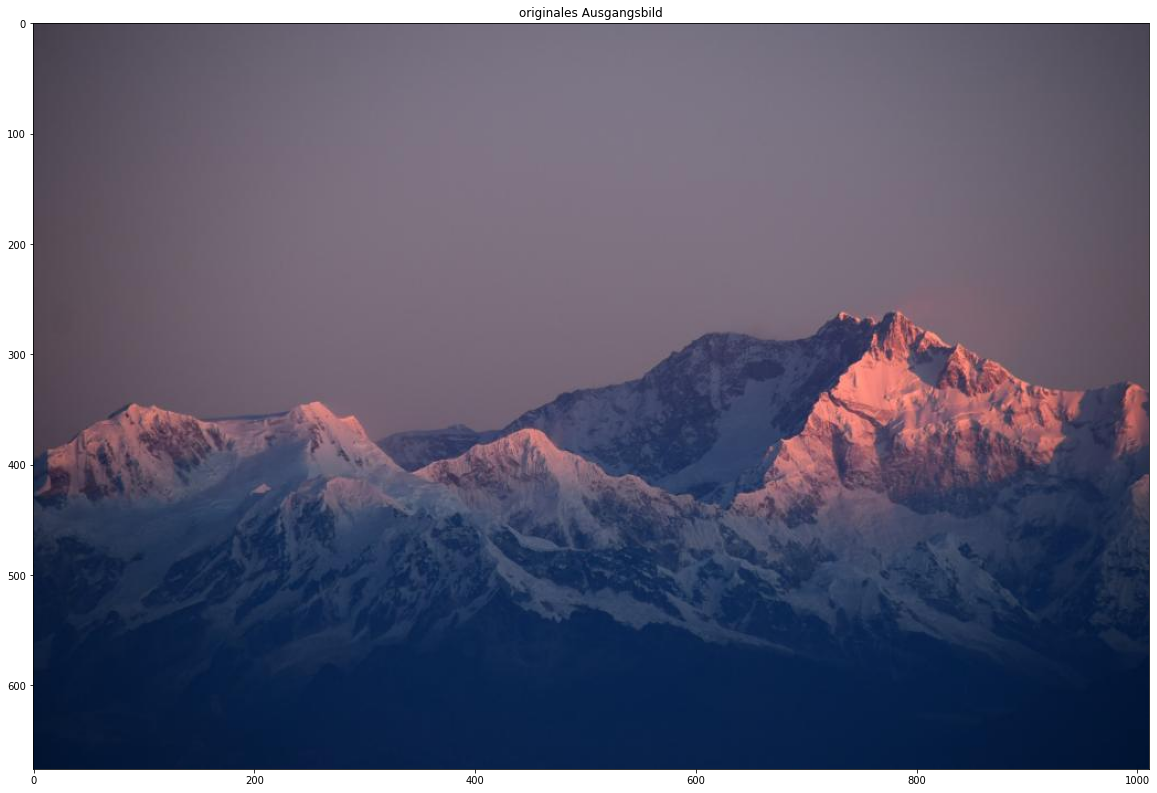

In [ ]:
import cv2
import numpy as np
import cv2 as cv
from PIL import Image
from skimage import segmentation
from skimage.color import label2rgb
# importieren zur Darstellung von Bildern im Notebook
from matplotlib import pyplot as plt
# zur Darstellung der Superpixel im Notebook
from skimage.segmentation import mark_boundaries

# Platzhalter der Webapp eingefügt
k = 15 # Anzahl der Farben
zonen_toleranz = 50 # Anzahl an Pixeln der kleinst erlaubtesten Zone
narrow_toleranz = 5 # Anzahl an Pixeln der schmalst erlaubtesten Zone

# Variablen defininiere, für Schwierigkeitsgrad ggf. ändern
first_blur = 17
second_blur = 11
zone_size_threshold = 75000
slic_segments = 1000

# Bild einfügen
img = cv2.imread('mountain.jpeg')
show_og_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# zur Ausgabe im Notebook
plt.figure(figsize=(20, 20))
plt.title('originales Ausgangsbild')
plt.imshow(show_og_img)

Da Bilder ziemlich groß werden können, entschieden wir uns dazu, die Bilder automatisch zu skalieren, sobald sie zu klein oder zu groß sind.
Hierzu nehmen wir die Standardwerte für ein kleines Bild mit 1333×750.

Es wird die Größe vom Bild eingeladen und ein Wert zum Auf und Abskalieren festgelegt (w und h).
Um beide Seiten gleich zu skalieren, wird ein index von 0 aus erhöht.
Somit kann die Anzahl der Skalierung für die Breite im Nachhinein auch auf die Höhe angewendet werden.

Bei der Skalierung wird der berechnete Wert "w" solange auf die Breite drauf addiert oder subtrahiert, bis diese den "max" Wert von 1333 erreicht hat.
Ist dies der Fall, wird die Höhe ebenfalls in derselben Anzahl der Skalierungen (index) skaliert.
Somit ist das Resultat eine Skalierung um den Bereich der Weite von 1333.

Dies erhöht die Effizienz des Algorithmus, was den Faktor der Zeit betrifft.
Die Algorithmen müssen nun keine großen Bilder mehr bearbeiten und können somit wesentlich schneller funktionieren.

In [ ]:
# Standardwert   
max = 1333

# Größe vom Bild abfragen
size = img.shape
height = size[0]
width = size[1]

print("Größe vorher: ", width, height)
# 1500 * 700 => 150 & 70
w = width / 10
h = height / 10

# Anzahl an Skalierungen
index = 0
if width > height:
    if width < max:
        while width < max:
            width = width + w
            index = index + 1
        height = height + (index * h)
    else:
        while width > max:
            width = width - w
            index = index + 1
        height = height - (index * h)
else:
    if height < max:
        while height < max:
            height = height + h
            index = index + 1
        width = width + (index * w)
    else:
        while height > max:
            height = height - h
            index = index + 1
        width = width - (index * w)

print("Größe nachher: ", int(width), int(height))

img = cv2.resize(img, (int(width), int(height)))

Größe vorher:  1011 676
Größe nachher:  1415 946


## **3.1.2: Erste Anwendung von k-Means**

Wir wollen nun zunächst, dass das Bild vereinfacht wird und nur noch *k* verschiedene Farben hat. Dafür rufen wir unsere k_means Methode auf, übergeben ihr unser Bild, *k* die Anzahl der Farben und eine Kernel-Größe zum Weichzeichnen. 

Zuerst wenden wir einen Gauss-Filter an, um das Bild weichzuzeichnen und den Detailgrad bereits etwas zu verringern und um den k-Means Algorithmus zu verbessern. Dann wird das Bild in das richtige Format für die Weiterverarbeitung konvertiert.

Die k-means Methode von opencv clustert nun ähnliche Farben in *k* verschiedene Gruppen. Es werden vereinfacht gesagt *k* verschiedene Durchschnittsfarben des Bildes berechnet. Dann wird jeder Pixel des Bildes zu einer dieser *k*-Farben zugeordnet. Dadurch werden klar erkennbare und unterscheidbare Bereiche erzeugt, die jeweils einer der *k*-Farben haben. Das Bild wird dann wieder zurückkonvertieert und zurückgegeben.

Als Ergebnis haben wir ein Bild, das nur noch *k* verschiedene Farben hat und bereits etwas vereinfacht wurde.

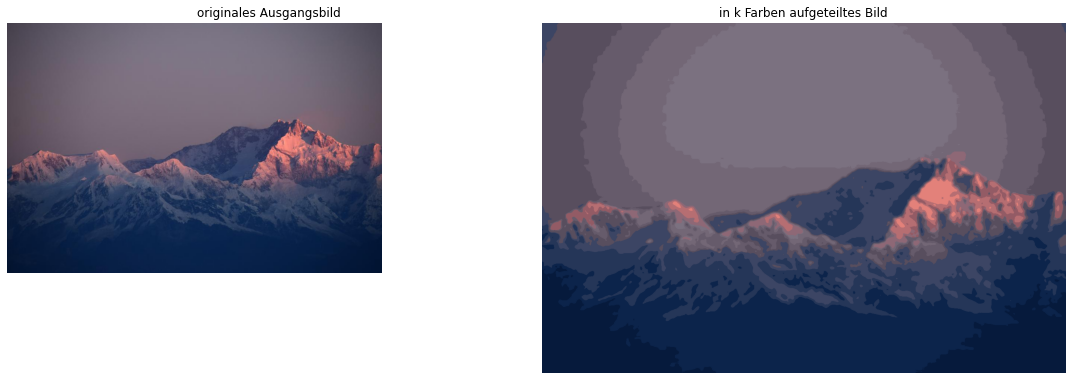

In [ ]:
def k_means(img, blur_kernel_size, k):
    # das Bild wird geblurrt, zur besseren Weiterverarbeitung
    tmp_img = cv.GaussianBlur(img, (blur_kernel_size, blur_kernel_size), 0)

    # dasd Bildarray wird umgeformt und zu float32 konvertiert (ist durch cv2 unit8)
    tmp_img = tmp_img.reshape((-1, 3))
    tmp_img = np.float32(tmp_img)

    # die Kriterien und die Anzahl der Farben für kmeans werden definiert und kmeans dann angewendet
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    ret, label, center = cv.kmeans(tmp_img, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    # das Bildarray wird wieder zurück in uint8 konvertiert und wieder in die ursprüngliche Form umgeformt
    center = np.uint8(center)
    res = center[label.flatten()]
    result_img = res.reshape(img.shape)

    # das Resultat wird zurückgegeben
    return result_img, center

k_means_img = k_means(img, 17, 12)[0]

# zur Ausgabe im Notebook
show_k_means_img = cv.cvtColor(k_means_img, cv2.COLOR_BGR2RGB)
fig, ax_arr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 15))
ax1, ax2 = ax_arr.ravel()

ax1.imshow(show_og_img)
ax1.set_title('originales Ausgangsbild')

ax2.imshow(show_k_means_img)
ax2.set_title('in k Farben aufgeteiltes Bild')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## **3.1.3: Superpixel erstellen**

Wir haben nun ein Bild, welches in verschiedene Cluster aufgeteilt wurde, die alle zu einer der k Farben gehören. Das Bild ist damit hinsichtlich der Zielsetzung schon um einiges vereinfacht worden und viele kleine Details wurden entfernt. Dennoch sind diese Cluster oft noch sehr klein und verwinkelt. Dieses Bild als Vorlage zum Ausmalen zum nehmen würde damit noch viel zu schwierig sein. Unser nächstes Ziel ist es nun also grössere Zonen/Cluster erstellen zu können.

Dafür geeignet wäre es, Pixel in Superpixeln zu gruppieren. Damit würde das Bild grobmaschiger segmentiert werden und die Detailtiefe und Komplexität des Bildes geht verloren und das ist was wir wollen. 

Dafür verwenden wir den SLIC-Algorithmus (Simple Linear Iterative Clustering) von **skimage**. Dieser Algorithmus clustert nun Pixel, die sich in ihrer Farbe und Textur ähneln und eine räumliche Beziehung haben, zu Superpixeln zusammen.
Mit der Methode label2rgb wird der Superpixel dann mit dem Durchschnitt der Farbe des Superpixels ausgefüllt. Wir haben nun ein Bild, welches in grössere Zonen unterteilt wurde, deren Grösse nun unseren Kriterien zum Erstellen eines Ausmalbildes entsprechen.

Zuvor müssen wir aber noch einen kleinen Zwischenschritt machen und das Bild welches durch die vorherige Verwendung von OpenCV in BGR codiert ist, in RGB konvertieren.

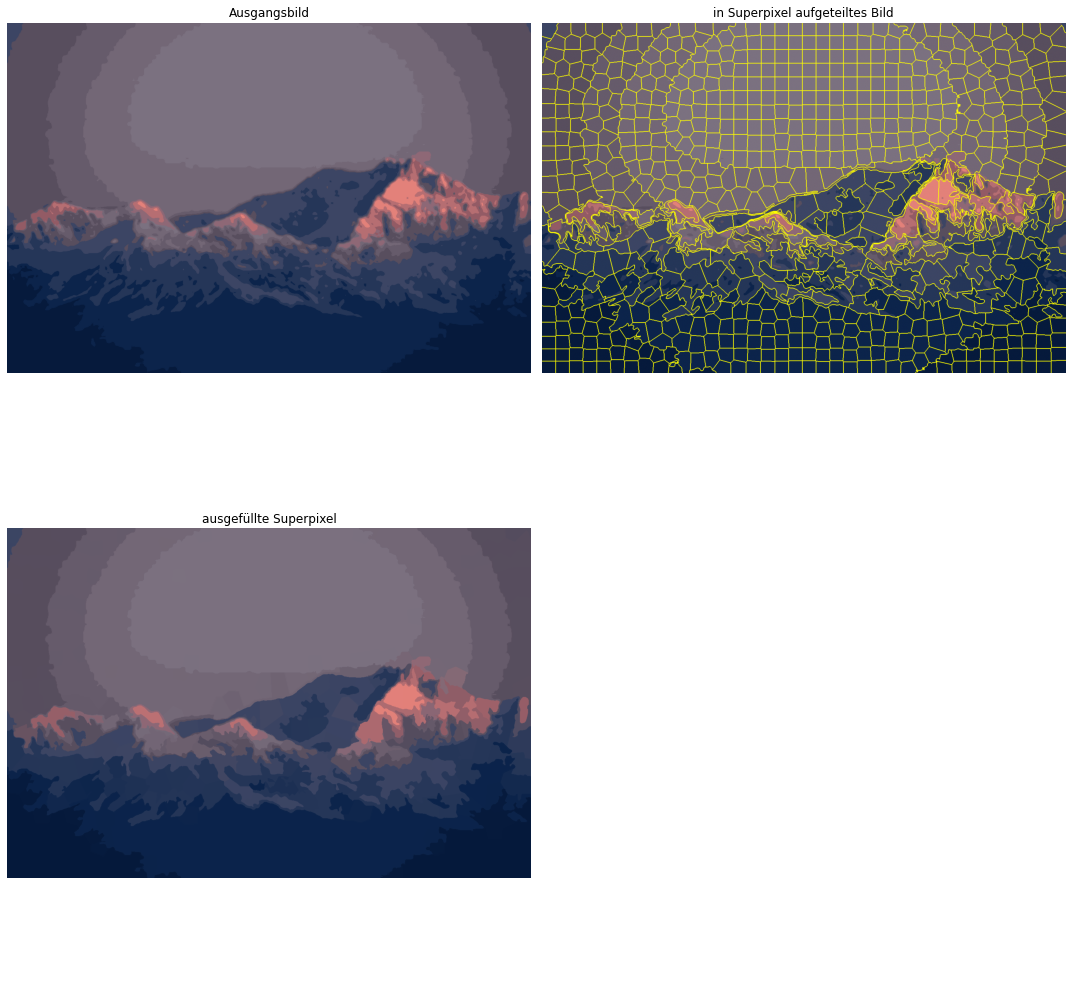

In [ ]:
# opencv benutzt standardmässig BGR, wir brauchen nun aber RGB: Daher wird das Bild nun in RGB konvertiert
tmp_img = cv.cvtColor(k_means_img, cv2.COLOR_BGR2RGB)

# !NUR IN JUPYTER NOTEBOOK NOTWENDIG! unit8-np.array wird ind float32-np.array umgewandelt 
tmp_img = tmp_img /255
tmp_img = np.float32(tmp_img)

# SLIC wird auf den unmaskierten Teil des Bildes angewandt und das Bild wird in Superpixel segmentiert
slic = segmentation.slic(tmp_img, n_segments=1000, compactness=1, start_label=1)

# die durchschnittliche Farbe eines Superpixel wird nun verwendet um diesen Superpixel auszufüllen
show_slic_img = label2rgb(slic, tmp_img, kind='avg', bg_label = -1)

# zur Ausgabe im Notebook
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 15))
ax1, ax2, ax3, ax4 = ax_arr.ravel()
ax1.imshow(show_k_means_img)
ax1.set_title('Ausgangsbild')

ax2.imshow(segmentation.mark_boundaries(show_k_means_img, slic))
ax2.set_title('in Superpixel aufgeteiltes Bild')

ax3.imshow(show_slic_img)
ax3.set_title('ausgefüllte Superpixel')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

### **Problem:**

Bei Bildern mit einem Hintergrund, wie dem Himmel in diesem Beispiel, kommt es dazu, das der Algorithmus Superpixel an der Grenze vom Vordergrund zum Hintergrund, erstellt. Dadurch verschwimmt, wie wir an diesem Ausschnitt des Bildes sehen können, der Hintergrund mit dem Vordergrund. (Das gilt auch für sonstige grosse Flächen die in Bildern vorkommen können.)


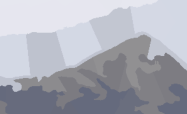

Hintergründe sind meistens grosse Flächen die keine grosse Farbdiversität haben, wodurch diese durch k-Means meistens schon zu grossen Zonen geclustert wurden. 

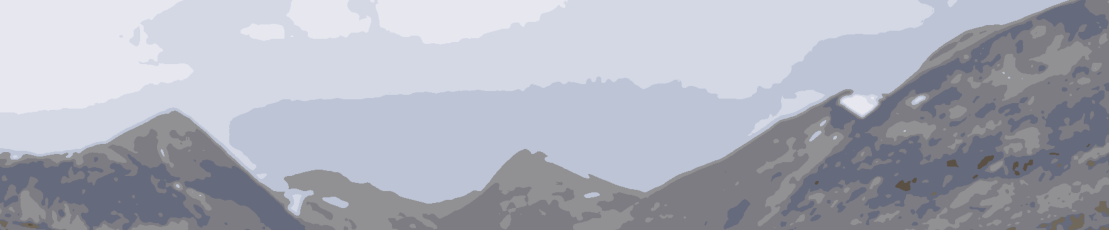

Da diese Flächen gross und ohne Details sind und damit schon bereits den Kriterien für unser Ziel entsprechen, brauchen wir diese gar nicht zu Superpixeln zu clustern. Sie sind in diesem Sinne schon Superpixel und diese Bereiche brauchen daher nicht vom SLIC-Algorithmus betrachtet werden. Wenn der SLIC-Algorithmus diese Teile also nun nicht betrachten würde, würde der Vordergrund nicht mit dem Hintergrund verschwimmen und es könnten unnötige Berechnungen eingespart werden.

### **Lösung: Maske erstellen, damit grosse Bereiche nicht mit berechnet werden**

Damit der SLIC-Algorithmus die großen Flächen nicht mitbetrachtet, werden wir nun eine Maske erstellen. Diese erstellen wir mit Hilfe eines Algorithmus von uns, den wir zum Erkennen von Zonen geschrieben und jetzt zur Erstellung der Maske angepasst haben (an dieser Stelle wird daher hauptsächlich auf die Anpassungen eingegangen, welche die beiden neuen Methoden find_zone_and_color_them und create_mask darstellen). Der angepasste Algorithmus findet Zonen, die größer sind als der angegebene Schwellenwert und erstellt dann eine Maske. 

Dafür wird die create_mask Methode mit unserem Bild als numpy.array und dem gewünschten Schwellenwert aufgerufen. Diese Methode konvertiert erst das numpy.array in eine PIL.Image Datei, erstellt dann ein komplett schwarzes Bild, das die gleichen Maẞe wie unser übergebenes Bild, hat, ruft dann die find_zones_and_color_them Methode auf und übergibt ihr die beiden Bilder und den Schwellenwert. 

Diese Methode geht die Pixel des ersten Bildes durch und speichert anhand deren Farbe, räumlich zusammengehörende Bereiche/Pixel mit gleicher Farbe als Zonen in ein Array ab. Nachdem alle Pixel einer Zone zugeordnet wurden, wird dieses Array durchgegangen und alle Zonen, deren Pixelanzahl geringer ist als unser Schwellenwert, werden nochmal in einem weiteren Array abgespeichert. Diese kleine Zonen werden nun, als weiße Zonen, in das schwarze Bild eingefügt. Damit hätten wir nun unsere vorzeitige Maske, welche die Methode zurückgibt.

In create_mask wird die Maske nun noch zur Weiterverarbeitung in ein numpy.array und dann von RGB in Grayscale umgewandelt (Wir haben nicht direkt ein Grayscale Bild sondern ein RGB Bild erstellt, weil sonst der Rest des Alogorithmus weitgehend hätte angepasst werden müssen).

Wir haben nun auf diese Weise eine Maske erstellt. Diese hat jedoch innerhalb der schwarzen Zonen viele kleine weiße Zonen.

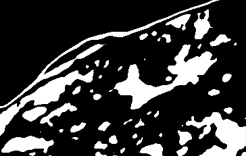

Dies kann dazu führen, dass wir bei der späteren Bearbeitung unschönes Rauschen bekommen. 

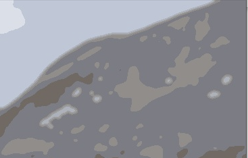

Um das zu verhindern, wollen wir die kleinen weißen Zonen schließen. Für diese Aufgabe liegen morphologische Filter nahe. Diese hatte aber unschöne Nebeneffekte, da sie eben nicht nur die Löcher schließen sondern auch die anderen Teile des Bildes beeinflussen.

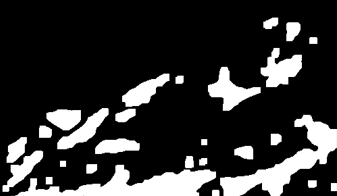


Wenn wir im Algorithmus direkt zu kleiner Felder ausschliessen würden. Wir also nicht nut eine Obergrenze, sondern auch eine Untergrenze festlegen würden. Hätten wir dann das umgedrehte Problem, dass wir innerhalb der weißen Flächen kleine schwarze Bereiche hätten.


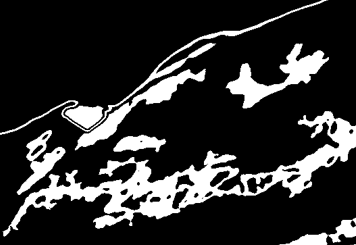


Unsere Lösung ist nun, dass create_mask nochmal find_zones_and_color_them mit der Maske und einem wesentlich kleineren Schwellenwert aufruft. Wieder suchen wir nach Zonen die kleiner sind als der Schwellenwert und speichern diese in ein Array ab. Diesmal werden die Zonen nicht nur in der Maske gesucht, sondern auch direkt in dieses, anstatt in ein anderes dafür erstelltes Bild, übertragen. Die Zonen die kleiner sind, als der Schwellenwert, werden dann auf der Maske anstatt weiß schwarz eingefärbt. Damit haben wir die Löcher geschlossen und die verbesserte Maske wird zurückgegeben. 


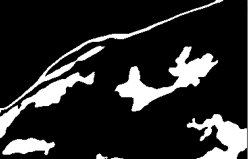

Durch die Verbesserung der Maske konnte das unschöne Rauschen beseitigt werden.

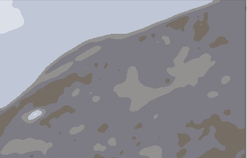

create_mask wandelt diese Maske wieder in das Format, dass wir brauchen um und gibt dann unsere verbesserte Maske zurück. (Zum Vergleich der Ergebnisse, werden beide Masken zurückgegebn). Somit haben wir unsere Maske zur Anwendung mit SLIC erstellt.


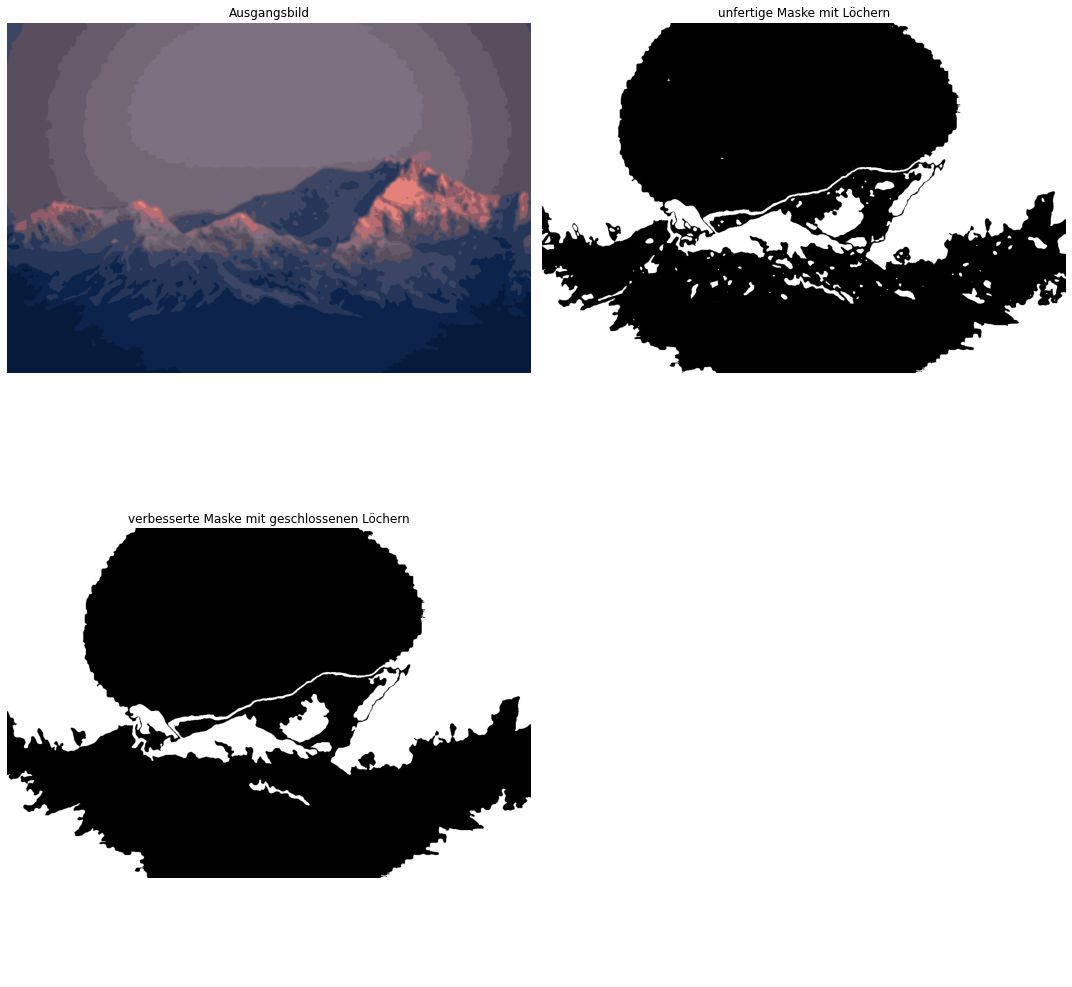

In [ ]:
# erstellt pixel matrix in Größe des Bildes: 0 = unbenutzt, 1 = benutzt
def createPixelList(size_x_1, size_y_1):
    pixel_list = np.zeros((size_x_1, size_y_1))
    return pixel_list


# erstellt pixel matrix in Größe des Bildes: 0 = unbenutzt, 1 = benutzt
def createZonePixelList(size_x_1, size_y_1):
    zone_pixel_list = np.zeros((size_x_1, size_y_1))
    return zone_pixel_list


# überprüft Nachbarn des Pixels
def checkNeighbour(x, y, pixel_matrix, pixel_zone_matrix, pixel_colour, colour_of_zone, size_x, size_y, index_of_zone,
                   colour_toleranz):
    # erstellt Array der Zone [x,y]
    zone = []
    # erstellt Warteschlangenarray [x,y]
    queue_to_check = [[x, y]]
    # hakt Pixel ab, dass er einer Zone hinzugefügt wurde
    pixel_matrix[x, y] = True
    # trägt dem Pixel seine Zone als Integer ein
    pixel_zone_matrix[x, y] = index_of_zone

    # solange ein Pixel in der Warteschlange ist
    while len(queue_to_check) >= 1:
        # übernimmt ersten Pixel aus der Warteschlange, entfernt diesen dort und fügt Zone hinzu
        x_to_check = queue_to_check[0][0]
        y_to_check = queue_to_check[0][1]
        queue_to_check.pop(0)
        zone.append([x_to_check, y_to_check])

        # prüft von-Neumann-Nachbarn oben
        if y_to_check != 0 and not pixel_matrix[x_to_check, y_to_check - 1]:
            # nehme Farbe des zu prüfenden Pixels und schaue, ob diese im Toleranz Bereich zur Zone liegt
            colour = pixel_colour[x_to_check, y_to_check - 1]
            if colour_of_zone[0] + colour_toleranz >= colour[0] >= colour_of_zone[0] - colour_toleranz and \
                    colour_of_zone[1] + colour_toleranz >= colour[1] >= \
                    colour_of_zone[1] - colour_toleranz and colour_of_zone[2] + colour_toleranz >= colour[2] >= \
                    colour_of_zone[2] - colour_toleranz:
                # füge Pixel zur Warteschlange hinzu, trage ihn als Zone zugewiesen ein und trage Zonen index ein
                queue_to_check.append([x_to_check, y_to_check - 1])
                pixel_matrix[x_to_check, y_to_check - 1] = True
                pixel_zone_matrix[x_to_check, y_to_check - 1] = index_of_zone
        # prüft von-Neumann-Nachbarn rechts
        if x_to_check + 1 < size_x and not pixel_matrix[x_to_check + 1, y_to_check]:
            # nehme Farbe des zu prüfenden Pixels und schaue, ob diese im Toleranz Bereich zur Zone liegt
            colour = pixel_colour[x_to_check + 1, y_to_check]
            if colour_of_zone[0] + colour_toleranz >= colour[0] >= colour_of_zone[0] - colour_toleranz and \
                    colour_of_zone[1] + colour_toleranz >= colour[1] >= \
                    colour_of_zone[1] - colour_toleranz and colour_of_zone[2] + colour_toleranz >= colour[2] >= \
                    colour_of_zone[2] - colour_toleranz:
                # füge Pixel zur Warteschlange hinzu, trage ihn als Zone zugewiesen ein und trage Zonen index ein
                queue_to_check.append([x_to_check + 1, y_to_check])
                pixel_matrix[x_to_check + 1, y_to_check] = True
                pixel_zone_matrix[x_to_check + 1, y_to_check] = index_of_zone
        # prüft von-Neumann-Nachbarn unten
        if y_to_check + 1 < size_y and not pixel_matrix[x_to_check, y_to_check + 1]:
            # nehme Farbe des zu prüfenden Pixels und schaue, ob diese im Toleranz Bereich zur Zone liegt
            colour = pixel_colour[x_to_check, y_to_check + 1]
            if colour_of_zone[0] + colour_toleranz >= colour[0] >= colour_of_zone[0] - colour_toleranz and \
                    colour_of_zone[1] + colour_toleranz >= colour[1] >= \
                    colour_of_zone[1] - colour_toleranz and colour_of_zone[2] + colour_toleranz >= colour[2] >= \
                    colour_of_zone[2] - colour_toleranz:
                # füge Pixel zur Warteschlange hinzu, trage ihn als Zone zugewiesen ein und trage Zonen index ein
                queue_to_check.append([x_to_check, y_to_check + 1])
                pixel_matrix[x_to_check, y_to_check + 1] = True
                pixel_zone_matrix[x_to_check, y_to_check + 1] = index_of_zone
        # prüft von-Neumann-Nachbarn links
        if x_to_check != 0 and not pixel_matrix[x_to_check - 1, y_to_check]:
            # nehme Farbe des zu prüfenden Pixels und schaue, ob diese im Toleranz Bereich zur Zone liegt
            colour = pixel_colour[x_to_check - 1, y_to_check]
            if colour_of_zone[0] + colour_toleranz >= colour[0] >= colour_of_zone[0] - colour_toleranz and \
                    colour_of_zone[1] + colour_toleranz >= colour[1] >= \
                    colour_of_zone[1] - colour_toleranz and colour_of_zone[2] + colour_toleranz >= colour[2] >= \
                    colour_of_zone[2] - colour_toleranz:
                # füge Pixel zur Warteschlange hinzu, trage ihn als Zone zugewiesen ein und trage Zonen index ein
                queue_to_check.append([x_to_check - 1, y_to_check])
                pixel_matrix[x_to_check - 1, y_to_check] = True
                pixel_zone_matrix[x_to_check - 1, y_to_check] = index_of_zone
    return zone, pixel_matrix, pixel_zone_matrix



'''
    Findet alle Zonen in einem Bild die kleiner sind, als der übergegebene Schwellenwert und übertragt diese Zonen
    an gleicher Stelle in ein zweites gleich grösses Bild in der angegebenen Farbe
    
    Anmerkung: Für unsere Zwecke wäre es zwar sinnvoller gewesen direkt ein Binary oder Grayscale Bild zu erstellen,
    anstatt ein schwarz-weiss Bild, das trotzdem in RGB codiert ist. Jedoch funktioniert die CheckNeighbour-Methode
    nur mit RGB-Bildern und um diese nicht extra umschreiben zu müssen, wird das Bild in RGB erstellt und dann 
    umgewandelt

    Parameters
    ----------
    img1 : PIL.Image.Image
        Das erste Bild in denen die Zonen gesucht werden soll
    img2 : PIL.Image.Image
        Das zweite Bild in denen die Zonen übertragen werden sollen
    size_x
        die Breite der Bilder
    size_y 
        die Höhe der Bilder
    zone_size_threshold
        der Schwellenwert für die Zonengrösse
    color_code
        der Farbcode für die Färbung der Zellen

    Returns
    -------
    img_2 : PI.Image.Image
        das zweite Bild wird mit den neu übertragen Zonen zurückgegeben
'''


def find_zones_and_color_them(img1, img2, size_x, size_y, zone_size_threshold, color_code):
    # Spielraum der Farbe
    colour_toleranz = 0

    # lädt Matrix mit Pixel Farben
    pixel_colour = img1.load()

    # erstellt eine Liste für alle Zonen, die erkannt werden
    zone_list = []

    # erstellt boolean Matrix in größe des Bildes um erkannte Pixel abzuhaken
    pixel_matrix = createPixelList(size_x, size_y)

    # erstellt integer Matrix in größe des Bildes, um Zone des Pixels einzutragen
    pixel_zone_matrix = createZonePixelList(size_x, size_y)

    # Zonen Index, um den verschiedenen Pixeln eine Zone zuzuweisen
    index_of_zone = 0

    # gehe Pixel für Pixel des Bildes durch
    for x in range(0, size_x):
        for y in range(0, size_y):
            # wenn der Pixel zu keiner Zone gehört, suche alle Pixel, die aneinander liegen und dieselbe Farbe haben
            if not pixel_matrix[x, y]:
                colour_of_zone = pixel_colour[x, y]
                zone, pixel_matrix, pixel_zone_matrix = checkNeighbour(x, y, pixel_matrix, pixel_zone_matrix,
                                                                       pixel_colour, colour_of_zone, size_x, size_y,
                                                                       index_of_zone, colour_toleranz)
                zone_list.append(zone)

                # erhöht Zonen Index nach erkannter Zone
                index_of_zone = index_of_zone + 1

    # Array zur Speicherung der Zonen die kleiner als zoneSizeThreshold sind
    zone_list_small = []

    # fügt zone_list_small die Zonen zu, die kleiner als zoneSizeThreshold sind
    for p in range(0, len(zone_list)):
        if len(zone_list[p]) < zone_size_threshold:
            zone_list_small.append(zone_list[p])

    # die Zonen die kleiner als der Threshold sind, werden als weisse Zonen an den gleichen Koordinaten,
    # die sie im Ursprungs-Bild haben, in das Greyscale-Bild übertragen
    for p in range(0, len(zone_list_small)):
        for q in range(0, len(zone_list_small[p])):
            img2.putpixel((zone_list_small[p][q][0], zone_list_small[p][q][1]), color_code)

    return img2


'''
    Erstellt eine Maske des Bildes zur Weiterbearbeitung mit SLIC.
    Alle Bereiche die grösser als der Threshold sind werden maskiert, damit SLIC diese nicht beachtet
    Zudem werden Löcher in der Maske geschlossen die kleiner als 1000px sind

    Parameters
    ----------
    img : numpy.ndarray
        Das zu bearbeitende Bild als numpy.ndarray
    zone_size_threshold : int
        Der Schwellenwert den die Zonen unterbieten müssen, um nicht maskiert zu werden

    Returns
    -------
    result_mask : numpy.ndarray
        Die erstellte Maske wird als numpy.ndarray in Grayscale zurückgegeben
'''


def create_mask(img, zone_size_threshold):
    # das numpy.ndarray wird zu PIL.Image.Image umgewandelt
    img = Image.fromarray(img)
    # breite und höhe des Bildes
    size_x, size_y = img.size
    # erstellt ein komplett schwarzes RGB-Bild als PIL.Image.Image, welches die gleiche Grösse hat, wie unser Bild
    mask = Image.new("RGB", (size_x, size_y), (0, 0, 0))
    # Erstellung der Maske
    mask = find_zones_and_color_them(img, mask, size_x, size_y, zone_size_threshold, (255, 255, 255))

    # Umwandlung des PIL.Image.Image zu numpy.ndarray zur Weiterverarbeitung
    result_mask = np.array(mask)
    # Umwandlung des numpy.array von rgb in grayscale
    result_mask = rgb2gray(result_mask)

    # Schliessen von Löchern in der Maske
    result_closed_mask = find_zones_and_color_them(mask, mask, size_x, size_y, 1000, (0, 0, 0))
    # Umwandlung des PIL.Image.Image zu numpy.ndarray zur Weiterverarbeitung
    result_closed_mask = np.array(result_closed_mask)
    # Umwandlung des numpy.array von rgb in grayscale
    result_closed_mask = rgb2gray(result_closed_mask)


    # das Resultat wird zurückgegeben (zur Veranschaulichung werden beide Masken zurückgegeben)
    return result_mask, result_closed_mask


'''
    Wandelt ein rgb-numpy array in grayscale um
    
    Parameters
    ---------
    
    rgb : numpy.ndarray
        das Bild das umgewandelt werden als numpy.ndarray in rgb
    
    Returns
    -------
    
    gray : numpy.ndarray
        das umgewandelte Bild als numpy.ndarray in grayscale
'''
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

unfinished_mask, mask = create_mask(k_means_img, 100000)


# zur Ausgabe im Notebook
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 15))
ax1, ax2, ax3, ax4 = ax_arr.ravel()
ax1.imshow(show_k_means_img)
ax1.set_title('Ausgangsbild')

ax2.imshow(unfinished_mask, cmap='gray')
ax2.set_title('unfertige Maske mit Löchern')


ax3.imshow(mask, cmap='gray')
ax3.set_title('verbesserte Maske mit geschlossenen Löchern')
for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

### **Superpixel erstellen mit Hilfe einer Maske**

Mit Hilfe unserer erstellten Maske können wir nun die Erstellung von Superpixeln verbessern. Dafür rufen wir unsere mask_slic Methode auf und übergeben ihr unser Bild, unsere Maske, und die Anzahl an Superpixeln die wir haben wollen. Diese konvertiert unser Bild wieder erst in RGB und ruft dann den SLIC-Algorithmus von skimage auf und übergibt ihm unsere drei Parameter. 

Das maskierte Bild wurde nun in Superpixel aufgeteilt und mit label2rgb von skimage wird für jedem Superpixel der Durchschnitt seiner Farbe berechnet und in dieser dann ausgefüllt. mask_slic gibt nun unser bearbeites Bild zurück (Zu Darstellungszwecken wird auch das Bild vor der Farbberechnung zurückgegeben).Zur weiteren Verarbeitung wird unser Bild von einem numpy.ndarray in eine PIL.Image Datei konvertiert.

Wir haben nun unser Bild, mit Hilfe von Superpixeln in gröẞere Bereiche unterteilt und sind dadurch unserem Ziel, das Bild zu vereinfachen näher gekommen. Dem verarbeitetem Bild fehlen aber nun die von der Maske maskierten Bereiche. Diese fügen wir im nächsten Schritt wieder ein.

Anmerkung: Da sich wie in Präsentation 6 vorgestellt, die Ergebnisse von unserem Code in PyCharm und im Jupyter Notebook unterscheiden, müssen wir hier unser Ergebnis von PyCharm nachahmen, in dem wir den schwarzen Bereich der Maske, über das mit SLIC bearbeitete Bild legen.

In [ ]:
def mask_slic(img, mask, slic_segments):
    # opencv benutzt standardmässig BGR, wir brauchen nun aber RGB: Daher wird das Bild nun in RGB konvertiert
    tmp_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # !NUR IN JUPYER NOTEBOOK! sonst funktioniert slic nicht
    tmp_img=tmp_img/255
    tmp_img= np.float32(tmp_img)

    # SLIC wird auf den unmaskierten Teil des Bildes angewandt und das Bild wird in Superpixel segmentiert
    m_slic = segmentation.slic(tmp_img, n_segments=slic_segments, mask=mask, compactness=1)

    # die durchschnittliche Farbe eines Superpixel wird nun verwendet um diesen Superpixel auszufüllen
    tmp_img = label2rgb(m_slic, tmp_img, kind='avg')

    # !NUR IN JUPYER NOTEBOOK! sonst funktioniert die Weiterverarbeitung nicht
    tmp_img= tmp_img * 255
    tmp_img= np.uint8(tmp_img)

    # das Resultat wird zurückgegeben
    return tmp_img, m_slic

tmp_slic_img, show_m_slic_img = mask_slic(k_means_img, mask, 1000)

# wandelt das numpy.ndarray zu PIL.Image.Image um (Grund: für die Weiterverarbeitung wird eine Image Datei und
# kein Array benötigt)
# aus Methode rausgezogen, da Notebook sonst Probleme mit der Ausgabe hat
slic_img = Image.fromarray(tmp_slic_img, 'RGB')

'''
!NUR IN JUPYER NOTEBOOK! wir machen den weißen Bereich der Maske transparent
und legen dann die Maske über unser Ergebnis um das Ergebnis, dass wir in 
PyCharm bekommen nachzuahmen

Quelle: https://www.geeksforgeeks.org/create-transparent-png-image-with-python-pillow/
'''

background = slic_img

foreground = Image.fromarray(mask)

foreground_rgba = foreground.convert("RGBA")

# das Bild wird in eine eindimensionale Sequenz von Pixeln gewandelt
datas = foreground_rgba.getdata()

new_data = []

# findet anhand des RGBA-Wertes weisse Farbe, und speichert diese dann anstatt schwarz als transparent ab
# andere Farben bleiben unverändert
for item in datas:
    
    if item[0] == 254 and item[1] == 254 and item[2] == 254:
        new_data.append((255, 255, 255, 0))
    else:
        new_data.append(item)

# die eindimensionale Sequenz von Pixeln wird wieder in ein Bild umgewandelt
foreground_rgba.putdata(new_data)
background.paste(foreground_rgba, (0, 0), mask=foreground_rgba)

slic_img = background

# zur Ausgabe
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 15))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(show_k_means_img)
ax1.set_title('Ausgangsbild')

ax2.imshow(mask, cmap='gray')
ax2.set_title('Maske')

ax3.imshow(segmentation.mark_boundaries(show_k_means_img, show_m_slic_img))
ax3.contour(mask, colors='red', linewidths=1)
ax3.set_title('in Superpixel aufgeteiltes Bild')

ax4.imshow(slic_img)
ax4.set_title('ausgefüllte Superpixel')

for ax in ax_arr.ravel():
    ax.set_axis_off()
slic_img.save("slic.png")
plt.tight_layout()
plt.show()

In [ ]:
# Quelle: https://www.geeksforgeeks.org/create-transparent-png-image-with-python-pillow/
background = slic_img

foreground = Image.fromarray(mask)

foreground_rgba = foreground.convert("RGBA")

print(foreground_rgba)
# das Bild wird in eine eindimensionale Sequenz von Pixeln gewandelt
datas = foreground_rgba.getdata()

new_data = []


# findet anhand des RGBA-Wertes weisse Farbe, und speichert diese dann anstatt schwarz als transparent ab
# andere Farben bleiben unverändert
for item in datas:
    
    if item[0] == 254 and item[1] == 254 and item[2] == 254:
        new_data.append((255, 255, 255, 0))
    else:
        new_data.append(item)

# die eindimensionale Sequenz von Pixeln wird wieder in ein Bild umgewandelt
foreground_rgba.putdata(new_data)
background.paste(foreground_rgba, (0, 0), mask=foreground_rgba)

slic_img = background

<PIL.Image.Image image mode=RGBA size=1415x946 at 0x7F5E60B6E040>


## **3.1.4: Zusammenfügen der erstellten Bilder**

Unser im letzten Schritt erstelltes Bild weist Lücken auf. Diese werden wir nun schliessen, in dem wir das mit Hilfe von SLIC erstellte Bild (Vordergrund) über das mit Hilfe von k-Means erstellte Bild (Hintergrund) fügen. Das sorgt dafür, dass die durch die Maske ausgeschlossenen Felder wieder eingefügt werden.

Dafür rufen wir die Methode combine_mask_slic_and_kmeans mit dem Vorder- und Hintergrund auf. Da wir Bereiche der Vordergrunds transparent machen müssen, wandeln wir den Vordergrund in RGBA um. Dann wandeln wir das Bild in eine eindimensionale Sequenz von Pixeln um und suchen in dieser anhand des Farbcode alle Pixel die schwarz sind und machen diese transparent. Das Bild wird dann wieder in seine ursprüngliche Dimension umgewandelt. Zum Zusammenfügen muss der Hintergrund noch ins richtige Format und in die richtige Farbcodierung konvertiert werden. Dann wird der Vordergrund auf den Hintergrund gelegt und wir geben das zusammengefügte Bild zurück. (Zur Veranschaulichung auch den Vordergrund mit dem transparenten Bereich)

Nun füllen die entsprechenden Bereiche des k-Means Bildes, die Lücken unseres mit SLIC erstellten Bildes und wir haben wieder ein vollständiges Bild, mit dem wir weiterarbeiten können.

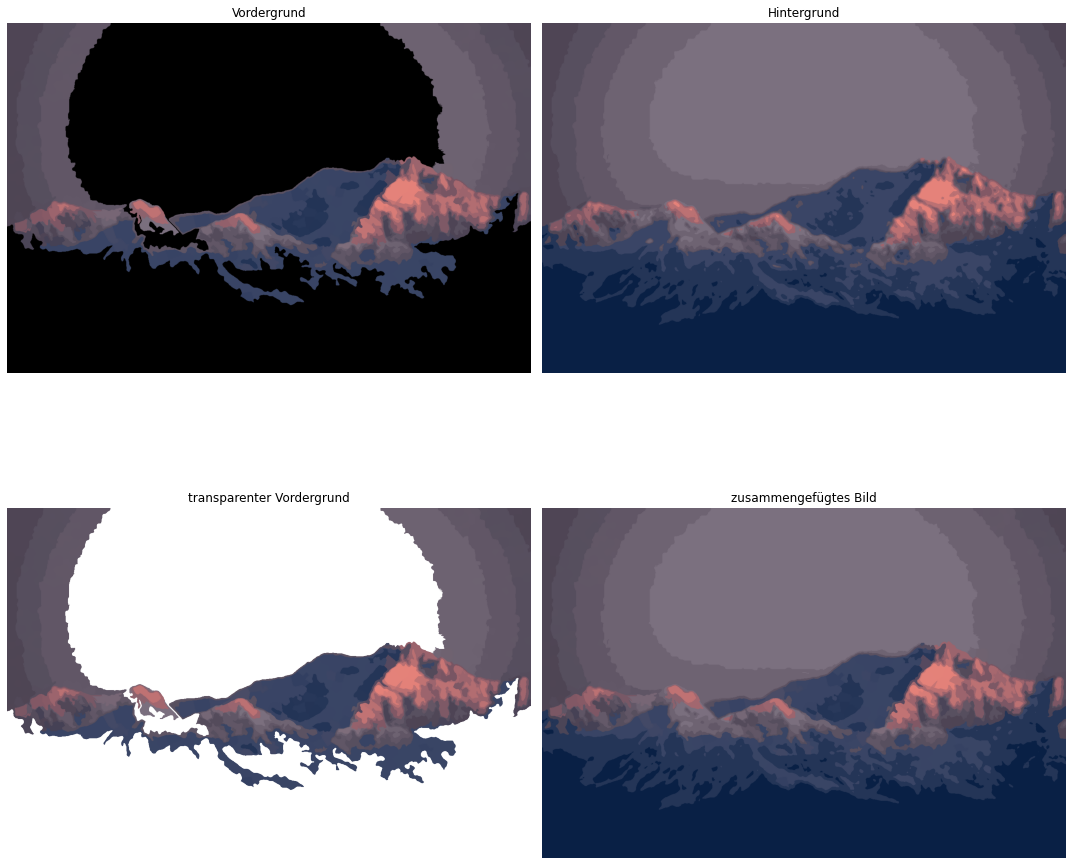

In [ ]:
'''
    Quelle: https://www.geeksforgeeks.org/create-transparent-png-image-with-python-pillow/
    Legt das durch SLIC erstellte Bild, welches durch die Maske nur ein Ausschnitt des gesamten Bildes ist, über
    das mit kMeans erstellte Bild, um wieder ein vollständiges Bild zu erhalten

    Parameters
    ----------
    foreground : PIL.Image.Image
        Der von SLIC bearbeitete Ausschnitt des Bildes der über das von kMeans erstellte Bild gelegt wird, als 
        PIL.Image.Image
    background : numpy.ndarray
        Das von kMeans erstellte Bild, auf das der Ausschnit gelegt wird, als numpy.ndarray

    Returns
    -------
    result_img : PIL.Image.Image
        Das zusammengefügte Bild als PIL.Image.Image
'''

def combine_mask_slic_and_kmeans(foreground, background):

    # konvertiert den Vordergrund zur RGBA
    foreground_rgba = foreground.convert("RGBA")

    # das Bild wird in eine eindimensionale Sequenz von Pixeln gewandelt
    datas = foreground_rgba.getdata()

    new_data = []

    # findet anhand des RGB-Wertes schwarze Farbe, und speichert diese dann anstatt schwarz als transparent ab
    # andere Farben bleiben unverändert
    for item in datas:
        if item[0] == 0 and item[1] == 0 and item[2] == 0:
            new_data.append((255, 255, 255, 0))
        else:
            new_data.append(item)

    # die eindimensionale Sequenz von Pixeln wird wieder in ein Bild umgewandelt
    foreground_rgba.putdata(new_data)

    # für Ausgabezwecke
    transparent_img = np.array(foreground_rgba)

    # der Hintergrund ist in BGR und muss in RGB umgewandelt
    background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)

    # der Hintergrund wird von numpy.ndarray in PIL.Image.Image umgewandelt
    background = Image.fromarray(background)

    # Fügt den Vordergrund auf den Hintergrund ein
    # fängt bei den Koordinaten (0,0) an
    background.paste(foreground_rgba, (0, 0), mask=foreground_rgba)

    result_img = background

    # Abspeicherung des Bildes zu Testzwecken
    result_img.save("testSLICandKCombined.png")

    # das Resultat wird zurückgegeben
    return result_img, transparent_img

combined_img, show_transparent_img = combine_mask_slic_and_kmeans(slic_img, k_means_img)

# zur Ausgabe
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 15))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(slic_img)
ax1.set_title('Vordergrund')

ax2.imshow(show_k_means_img)
ax2.set_title('Hintergrund')

ax3.imshow(show_transparent_img)
ax3.set_title('transparenter Vordergrund')

ax4.imshow(combined_img)
ax4.set_title('zusammengefügtes Bild')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## **3.1.5: Zweite Anwendung von k-Means**
Durch die Erstellung von Superpixeln haben wir ein wesentlich vereinfachteres Bild, mit wesentlich weniger Details. Dadurch haben wir aber auch wieder mehr als *k* Farben und grosse homogene Bereiche, die nicht maskiert wurden, wurden auch in Superpixel unterteilt und somit wieder in kleinere Bereich separiert.

Um wieder homogene Bereiche und *k* Farben zu haben, übergeben wir unser verarbeitetes Bild nochmal unserer k_means Methode, aber verringern diesmal die Weichzeichnung (empirisch ermittelt). Wir bekommen nun als Ergebnis ein abgerundetes Bild, mit Clustern in *k* verschiedenen Farben, zurück. Dieses Bild entspricht nun unserem Ziel der Bildverarbeitung: Wir haben ein vereinfachtes Bild erstellt, das in größere Zonen und *k* verschiedenen Farben aufgeteilt ist und so aussieht, als könne man es per Hand ausmalen. Mit diesem Bild können wir jetzt in den nächsten Schritte weiterarbeiten.


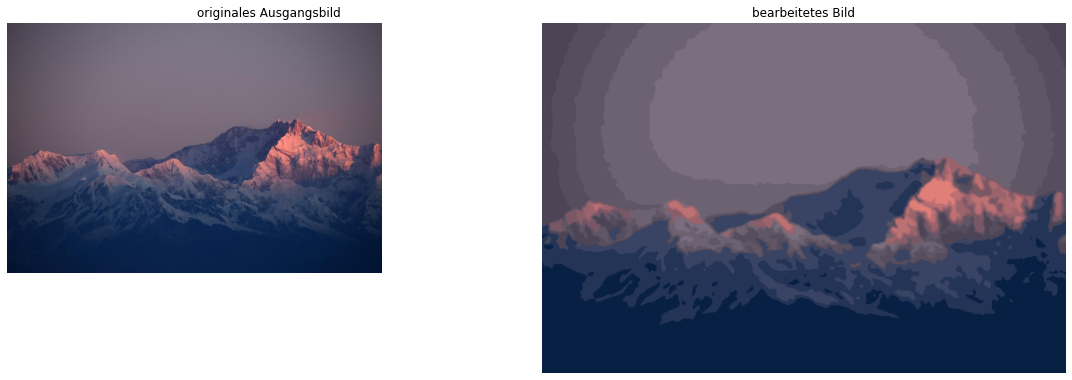

In [ ]:
# PIL.Image.Image in numpy.ndarray umwandeln
tmp_img = numpy.array(combined_img)

# numpy.ndarray wird von RGB in BGR umgewandelt
tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_RGB2BGR)

result, k_mean_colour = k_means(tmp_img, second_blur, k)

# zur Ausgabe
fig, ax_arr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 15))
ax1, ax2 = ax_arr.ravel()

ax1.imshow(show_og_img)
ax1.set_title('originales Ausgangsbild')

show_result_img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
ax2.imshow(show_result_img)
ax2.set_title('bearbeitetes Bild')

cv2.imwrite("kmean.jpg", result)

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## **3.1.6: Die einzelnen Zonen erkennen**
Um die richtigen Zahlen in die passende Farbzone eintragen zu können, muss zuerst das gesamte Bild in Zonen unterteilt werden.

Hierzu werden in der Main-Methode alle wichtige Variablen definiert:
- colour_toleranz = der Toleranzwert, um die Nachbar-Pixel nach Farbe zu überprüfen
- font_size = die Schriftgröße der Zahlen


In [ ]:
# Spielraum der farbe
colour_toleranz = 10
# größe der Zahlen
font_size = 0.4

# liest kmeans Bild ein und lädt Matrix mit Pixel Farben
image = Image.open('kmean.jpg')
pixel_colour = image.load()

# erstellt eine Liste für alle Zonen, die erkannt werden
zone_list = []

# breite und höhe des Bildes
size_x, size_y = image.size

Damit der Algorithmus effizienter Arbeiten kann, wurden zwei Array-Matrizen erstellt.
- pixel_matrix = Boolean Matrix in Größe des Bildes.
Jeder Pixel, der einer Zone hinzugefügt wurde, wird in dieser Matrix auf True gesetzt. 
=> Somit können Pixel, die einer Zone angehören, ignoriert und übersprungen werden
- pixel_zone_matrix = Integer Matrix in Größe des Bildes. Die Zonennummer (index_of_zone) jedes Pixels wird in dieser Matrix eingetragen. => Dies vereinfacht das spätere Berechnen für das Zentrum einer Zone.


In [ ]:
# erstellt pixel matrix in Größe des Bildes: 0 = unbenutzt, 1 = benutzt
def createPixelList(size_x_1, size_y_1):
    pixel_list = numpy.zeros((size_x_1, size_y_1))
    return pixel_list


# erstellt pixel matrix in Größe des Bildes: 0 = unbenutzt, 1 = benutzt
def createZonePixelList(size_x_1, size_y_1):
    zone_pixel_list = numpy.zeros((size_x_1, size_y_1))
    return zone_pixel_list

# erstellt boolean Matrix in größe des Bildes um erkannte Pixel abzuhaken
pixel_matrix = createPixelList(size_x, size_y)

# erstellt integer Matrix in größe des Bildes, um Zone des Pixels einzutragen
pixel_zone_matrix = createZonePixelList(size_x, size_y)

Nun überprüft eine For-Schleife jeden Pixel des Bildes.
Gehört der Pixel keiner Zone an (not pixel_matrix[x, y]), wird für den jeweiligen Pixel eine neue Zone mit der Zonennummer (index_of_zone) zusammengestellt.

Der Pixel wird einem Warteschlangenarray (queue_to_check) hinzugefügt, um die While-Schleife zu aktivieren. 
Diese Schleife wird solange durchlaufen, bis kein Pixel mehr zu überprüfen ist.

Die While-Schleife überprüft die von-Neumann-Nachbarschaft (Nord, Ost, Süd, West) des ersten Pixels aus dem Warteschlangenarray.
Gehört der Nachbarpixel zu derselben Farbgruppe (colour_toleranz) wie der zu überprüfende Pixel, so wird der Nachbarpixel dem Warteschlangenarray hinzugefügt, in der "pixel_matrix" als True gesetzt und die Zonennummer in der "pixel_zone_matrix" eingetragen.

Wenn das Warteschlangenarray keinen Inhalt mehr besitzt, wurden alle Pixel der Zone erkannt und die Zone wird zurückgegeben, um sie der Zonenliste (zone_list) hinzuzufügen.

In [ ]:
# überprüft Nachbarn des Pixels
def checkNeighbour(x, y, pixel_matrix, pixel_zone_matrix, pixel_colour, colour_of_zone, size_x, size_y, index_of_zone,
                   colour_toleranz):
    # erstellt Array der Zone [x,y]
    zone = []
    # erstellt Warteschlangenarray [x,y]
    queue_to_check = [[x, y]]
    # hakt Pixel ab, dass er einer Zone hinzugefügt wurde
    pixel_matrix[x, y] = True
    # trägt dem Pixel seine Zone als Integer ein
    pixel_zone_matrix[x, y] = index_of_zone

    # solange ein Pixel in der Warteschlange ist
    while len(queue_to_check) >= 1:
        # übernimmt ersten Pixel aus der Warteschlange, entfernt diesen dort und fügt Zone hinzu
        x_to_check = queue_to_check[0][0]
        y_to_check = queue_to_check[0][1]
        queue_to_check.pop(0)
        zone.append([x_to_check, y_to_check])

        # prüft von-Neumann-Nachbarn oben
        if y_to_check != 0 and not pixel_matrix[x_to_check, y_to_check - 1]:
            # nehme Farbe des zu prüfenden Pixels und schaue, ob diese im Toleranz Bereich zur Zone liegt
            colour = pixel_colour[x_to_check, y_to_check - 1]
            if colour_of_zone[0] + colour_toleranz >= colour[0] >= colour_of_zone[0] - colour_toleranz and \
                    colour_of_zone[1] + colour_toleranz >= colour[1] >= \
                    colour_of_zone[1] - colour_toleranz and colour_of_zone[2] + colour_toleranz >= colour[2] >= \
                    colour_of_zone[2] - colour_toleranz:
                # füge Pixel zur Warteschlange hinzu, trage ihn als Zone zugewiesen ein und trage Zonen index ein
                queue_to_check.append([x_to_check, y_to_check - 1])
                pixel_matrix[x_to_check, y_to_check - 1] = True
                pixel_zone_matrix[x_to_check, y_to_check - 1] = index_of_zone
        # prüft von-Neumann-Nachbarn rechts
        if x_to_check + 1 < size_x and not pixel_matrix[x_to_check + 1, y_to_check]:
            # nehme Farbe des zu prüfenden Pixels und schaue, ob diese im Toleranz Bereich zur Zone liegt
            colour = pixel_colour[x_to_check + 1, y_to_check]
            if colour_of_zone[0] + colour_toleranz >= colour[0] >= colour_of_zone[0] - colour_toleranz and \
                    colour_of_zone[1] + colour_toleranz >= colour[1] >= \
                    colour_of_zone[1] - colour_toleranz and colour_of_zone[2] + colour_toleranz >= colour[2] >= \
                    colour_of_zone[2] - colour_toleranz:
                # füge Pixel zur Warteschlange hinzu, trage ihn als Zone zugewiesen ein und trage Zonen index ein
                queue_to_check.append([x_to_check + 1, y_to_check])
                pixel_matrix[x_to_check + 1, y_to_check] = True
                pixel_zone_matrix[x_to_check + 1, y_to_check] = index_of_zone
        # prüft von-Neumann-Nachbarn unten
        if y_to_check + 1 < size_y and not pixel_matrix[x_to_check, y_to_check + 1]:
            # nehme Farbe des zu prüfenden Pixels und schaue, ob diese im Toleranz Bereich zur Zone liegt
            colour = pixel_colour[x_to_check, y_to_check + 1]
            if colour_of_zone[0] + colour_toleranz >= colour[0] >= colour_of_zone[0] - colour_toleranz and \
                    colour_of_zone[1] + colour_toleranz >= colour[1] >= \
                    colour_of_zone[1] - colour_toleranz and colour_of_zone[2] + colour_toleranz >= colour[2] >= \
                    colour_of_zone[2] - colour_toleranz:
                # füge Pixel zur Warteschlange hinzu, trage ihn als Zone zugewiesen ein und trage Zonen index ein
                queue_to_check.append([x_to_check, y_to_check + 1])
                pixel_matrix[x_to_check, y_to_check + 1] = True
                pixel_zone_matrix[x_to_check, y_to_check + 1] = index_of_zone
        # prüft von-Neumann-Nachbarn links
        if x_to_check != 0 and not pixel_matrix[x_to_check - 1, y_to_check]:
            # nehme Farbe des zu prüfenden Pixels und schaue, ob diese im Toleranz Bereich zur Zone liegt
            colour = pixel_colour[x_to_check - 1, y_to_check]
            if colour_of_zone[0] + colour_toleranz >= colour[0] >= colour_of_zone[0] - colour_toleranz and \
                    colour_of_zone[1] + colour_toleranz >= colour[1] >= \
                    colour_of_zone[1] - colour_toleranz and colour_of_zone[2] + colour_toleranz >= colour[2] >= \
                    colour_of_zone[2] - colour_toleranz:
                # füge Pixel zur Warteschlange hinzu, trage ihn als Zone zugewiesen ein und trage Zonen index ein
                queue_to_check.append([x_to_check - 1, y_to_check])
                pixel_matrix[x_to_check - 1, y_to_check] = True
                pixel_zone_matrix[x_to_check - 1, y_to_check] = index_of_zone
    return zone, pixel_matrix, pixel_zone_matrix

# Zonen Index, um den verschiedenen Pixeln eine Zone zuzuweisen
index_of_zone = 0

# gehe Pixel für Pixel des Bildes durch
for x in range(0, size_x):
    for y in range(0, size_y):
        # wenn der Pixel zu keiner Zone gehört, suche alle Pixel, die aneinander liegen und dieselbe Farbe haben
        if not pixel_matrix[x, y]:
            colour_of_zone = pixel_colour[x, y]
            zone, pixel_matrix, pixel_zone_matrix = checkNeighbour(x, y, pixel_matrix, pixel_zone_matrix,
                                                                    pixel_colour, colour_of_zone, size_x, size_y,
                                                                    index_of_zone, colour_toleranz)
            zone_list.append(zone)

            # erhöht Zonen Index nach erkannter Zone
            index_of_zone = index_of_zone + 1
    

Da einige Bilder zu kleine Zonen haben, um diese auszumalen, werden nun alle kleinen Zonen in ihre größeren Nachbarzonen gemergt.

Hierzu wird die "zone_list" mit einer for-Schleife durchlaufen.
Ist die Zone kleiner als die vorgegebene Toleranz (zonen_toleranz), so geht der Algorithmus wie folgt vor:
1. Überprüfe den Pixel nördlich und südlich in einer Entfernung von "check_index"
2. Gehört der Pixel zu der eigenen Zone (index_of_pixel)?
- Ja: ignoriere und wiederhole die 1.
- Nein: nehme den Index des Nachbarpixels (new_index)
3. Füge alle Pixel der alten Zone der neuen Zone des Indizes "new_index" hinzu

Nachdem alle kleinen Zonen in die größeren Zonen gemergt wurden,
werden nun alle Variablen aktualisiert:
  
    # lösche alle kleinen Zonen aus gesamter Zonen Liste
    delete = []
    # füge kleine Zonen der Löschliste hinzu = immer vorne einfügen, sonst ändert sich der Index all der anderen Zonen beim Entfernen
    for zone in range(0, int(len(zone_list))):
    if int(len(zone_list[zone])) < zonen_toleranz:
        delete.insert(0, zone)

    # entferne kleine Zonen aus der gesamten Zonen Liste
    for zone in range(0, len(delete)):
      zone_list.pop(delete[zone]) 

- delete = speichert alle Zonen, die gelöscht werden müssen

Da die for-Schleife von vorne nach hinten durchgeht, ist es wichtig, dass die "älteste" Zone nach ganz vorne gepackt wird (delete.insert(0, zone)).

Entfernt man nun die Zone aus der "zone_list", so verändert sich die Länge dieser Variable und somit auch der Index gewisser Zonen, die hinter der entfernten Zone liegen. Daher wurde die "älteste" Zone zuerst in die Liste eingefügt, da somit von hinten nach vorne die Zonen in der "zone_list" entfernt werden und es zu keinen Problem mit den Indizes der anderen Zonen gibt.

In [ ]:
# merged die kleinen Zonen in größere
def mergeSmallZones(zone_list, zonen_toleranz, pixel_zone_matrix, size_x):
    # geht komplette Zonen Liste durch
    for zone in range(0,int(len(zone_list))):
        # wenn die Zone < zonen_toleranz
        if int(len(zone_list[zone])) < zonen_toleranz:
            # nimm ersten Pixel aus der Zone
            pixel = zone_list[zone][0]
            pxl_x = pixel[0]
            pxl_y = pixel[1]
            # nimm den Zonen Index dieses Pixels
            index_of_pixel = int(pixel_zone_matrix[pxl_x, pxl_y])

            # speichert den neuen Zonen Index des Pixels ab
            new_index = 0

            # solange Nachbar Pixel zur selben Zone gehört, wird dieser Wert erhöht
            check_index = 1
            checked = False
            while not checked:
                # prüft von-Neumann-Nachbarn oben, ob der Pixel zu einer anderen Zone gehört
                if pxl_x - check_index >= 0 and pixel_zone_matrix[pxl_x - check_index, pxl_y] != index_of_pixel:
                    # möglicher neuer Index wird auf länge der Zone geprüft
                    ind = int(pixel_zone_matrix[pxl_x - check_index, pxl_y])
                    if len(zone_list[ind]) > 50:
                        new_index = pixel_zone_matrix[pxl_x - check_index, pxl_y]
                        break
                # prüft von-Neumann-Nachbarn unten, ob der Pixel zu einer anderen Zone gehört
                if pxl_x + check_index < size_x and pixel_zone_matrix[pxl_x + check_index, pxl_y] != index_of_pixel:
                    # möglicher neuer Index wird auf länge der Zone geprüft
                    ind = int(pixel_zone_matrix[pxl_x + check_index, pxl_y])
                    if len(zone_list[ind]) > 50:
                        new_index = pixel_zone_matrix[pxl_x + check_index, pxl_y]
                        break
                # erhöhe den Abstand zu nächsten Pixel
                check_index = check_index + 1

            # füge alle Pixel der kleinen Zone der neuen großen Zone hinzu und trage Zonen Index neu ein
            for p in range(0, len(zone_list[index_of_pixel])):
                zone_list[int(new_index)].append(zone_list[index_of_pixel][p])
                old_x = zone_list[index_of_pixel][p][0]
                old_y = zone_list[index_of_pixel][p][1]
                pixel_zone_matrix[old_x, old_y] = int(new_index)

    # lösche alle kleinen Zonen aus gesamter Zonen Liste
    delete = []
    # füge kleine Zonen der Löschliste hinzu = immer vorne einfügen, sonst ändert sich der Index all der anderen Zonen beim Entfernen
    for zone in range(0, int(len(zone_list))):
        if int(len(zone_list[zone])) < zonen_toleranz:
            delete.insert(0, zone)

    # entferne kleine Zonen aus der gesamten Zonen Liste
    for zone in range(0, len(delete)):
        zone_list.pop(delete[zone])

    return zone_list, pixel_zone_matrix
    
# merge alle kleinen Zonen in große Zonen
zone_list, pixel_zone_matrix = mergeSmallZones(zone_list, zonen_toleranz, pixel_zone_matrix, size_x)

Für die weitere Verwendung der "pixel_zone_matrix" müssen die Indizes von 0 bis zur Anzahl der Zonen sortiert werden. 
Hierzu wird eine for-Schleife ausgeführt, die jede Zone aus der "zone_list" durchgeht und von vorne nach hinten jedem Pixel in der "pixel_zone_matrix" dem jeweiligen Indize der Zone hinzufügt.

In [ ]:
# sortiert die Matrix der Zonen neu
def sortMatrix(zone_list, pixel_zone_matrix):
    for zone in range(0, len(zone_list)):
        for pixel in range(0, len(zone_list[zone])):
            pixel_zone_matrix[zone_list[zone][pixel][0], zone_list[zone][pixel][1]] = zone
    return pixel_zone_matrix

# sortiert die Indizes der Zonen  
pixel_zone_matrix = sortMatrix(zone_list, pixel_zone_matrix)

Da einige Bilder ebenfalls schmale Zonen besitzen,
werden diese nun rausgefiltert.

Diese Methode geht mit dem Finden des Zentrums für die Zahl einher.
Dazu wird jeder Pixel einer Zone überprüft.
Es wird geschaut, welcher Pixel in der Zone die meisten "von-Neumann-Nachbarn" aus derselben Zone besitzt.

Dieser Pixel muss das Zentrum der jeweiligen Zone sein.

Ist die Anzahl an "von-Neumann-Nachbarn" kleiner als ein bestimmter Toleranzwert, so kann die Zone entfernt werden.

Suchen wir nun erstmal nach den Centerpixeln der jeweiligen Zonen:

In [ ]:
# berechnet das Zentrum von jeder Zone
def calculateZoneCenters(size_x, size_y, zone_list, pixel_zone_matrix):
    # Liste aller Center-Pixel
    centers = []
    # Größe des jewiligen Zentrums
    centers_size = []

    # für alle Zonen
    for z in range(0, len(zone_list)):
        # berechne den Center-Pixel
        center, center_size = calculateZoneCenter(size_x, size_y, zone_list[z], pixel_zone_matrix)
        # füge den Center-Pixel der Liste hinzu
        centers.append(center)
        # füge die Zentrumsgröße der Liste hinzu
        centers_size.append(center_size)
    return centers, centers_size

# berechnet das Zentrum von einer Zone
def calculateZoneCenter(size_x, size_y, zone, pixel_zone_matrix):
    # nimm den Index der jeweiligen Zone
    zone_index = pixel_zone_matrix[int(zone[0][0]), int(zone[0][1])]
    # das größte Zentrum startet bei 0
    biggest_center = 0
    # Center-Pixel
    center = []
    # für alle Pixel in der Zone
    for p in range(0, len(zone)):
        x = zone[p][0]
        y = zone[p][1]
        # von-Neumann-Nachbarn starten bei 1
        center_size = 1
        bigger = True
        # solange größere Zone existiert
        while bigger:
            # ab einer größe von 50 Pixeln kann der Algorithmus beendet werden (dies reicht aus)
            if center_size <= 50:
                # prüfe oben
                if x - center_size > -1 and pixel_zone_matrix[x - center_size, y] == zone_index:
                    # prüfe rechts
                    if y + center_size < size_y and pixel_zone_matrix[x, y + center_size] == zone_index:
                        # prüfe unten
                        if x + center_size < size_x and pixel_zone_matrix[x + center_size, y] == zone_index:
                            # prüfe links
                            if y - center_size > -1 and pixel_zone_matrix[x, y - center_size] == zone_index:
                                center_size = center_size + 1
                            else:
                                bigger = False
                                break
                        else:
                            bigger = False
                            break
                    else:
                        bigger = False
                        break
                else:
                    bigger = False
                    break
                pass
            else:
                bigger = False
            # wenn das neue Zentrum größer    
            if biggest_center < center_size:
                # größtes Zentrum anpassen
                biggest_center = center_size
                # neuer Center-Pixel
                center = [x, y]
    return center, biggest_center

centers, centers_size = calculateZoneCenters(size_x, size_y, zone_list, pixel_zone_matrix)

Nachdem alle Zonen ihren Center-Pixel berechnet haben, wird eine Liste aller Center-Pixel und die Größe des Zentrums zurückgegeben.
Um den Algorithmus effizienter zu machen, determiniert dieser, sobald ein Pixel eine Zentrumsgröße von 50 überschreitet.
Dieser Pixel reicht aus, um eine Zahl in die Zone zu Printen.

Nun können alle Zonen, die schmaler als ein bestimmter Toleranzwert sind, gemergt werden. 
Dazu filtert man die Zonen mit einem Zonenzentrum kleiner als der Toleranzwert raus und mergt diese in den naheliegensten Nachbarn hinein.

In [ ]:
# merged die schmalen Zonen in ihre Nachbarn
def mergeNarrowZones(narrow_toleranz, centers, centers_size, pixel_zone_matrix, size_x, size_y, zone_list):
    # index Liste aller zonen, die gelöscht werden müssen
    delete = []

    # geht komplette center größen Liste durch
    for index in range(0, len(centers_size)):
        # wenn der center < narrow_toleranz
        if int(centers_size[index]) <= narrow_toleranz:
            # nimm den Center Pixel
            pixel = centers[index]
            pxl_x = pixel[0]
            pxl_y = pixel[1]
            # nimm den Zonen Index dieses Pixels
            index_of_pixel = int(pixel_zone_matrix[pxl_x, pxl_y])
            # füge diese Zoner zum Löschen hinzu
            delete.insert(0, pixel_zone_matrix[centers[index][0], centers[index][1]])
            # speichert den neuen Zonen Index des Pixels ab
            new_index = 0

            # solange Nachbar Pixel zur selben Zone gehört, wird dieser Wert erhöht
            check_index = 1
            checked = False
            while not checked:
                # prüft von-Neumann-Nachbarn links, ob der Pixel zu einer anderen Zone gehört
                if pxl_x - check_index >= 0 and pixel_zone_matrix[pxl_x - check_index, pxl_y] != index_of_pixel:
                    new_index = pixel_zone_matrix[pxl_x - check_index, pxl_y]
                    break
                # prüft von-Neumann-Nachbarn rechts, ob der Pixel zu einer anderen Zone gehört
                if pxl_x + check_index < size_x and pixel_zone_matrix[pxl_x + check_index, pxl_y] != index_of_pixel:
                    new_index = pixel_zone_matrix[pxl_x + check_index, pxl_y]
                    break
                # prüft von-Neumann-Nachbarn oben, ob der Pixel zu einer anderen Zone gehört
                if pxl_y - check_index >= 0 and pixel_zone_matrix[pxl_x, pxl_y - check_index] != index_of_pixel:
                    new_index = pixel_zone_matrix[pxl_x, pxl_y - check_index]
                    break
                # prüft von-Neumann-Nachbarn unten, ob der Pixel zu einer anderen Zone gehört
                if pxl_y + check_index < size_y and pixel_zone_matrix[pxl_x, pxl_y + check_index] != index_of_pixel:
                    new_index = pixel_zone_matrix[pxl_x, pxl_y + check_index]
                    break

                # erhöhe den Abstand zu nächsten Pixel
                check_index = check_index + 1

            # füge alle Pixel der kleinen Zone der neuen großen Zone hinzu und trage Zonen Index neu ein
            for p in range(0, len(zone_list[index_of_pixel])):
                zone_list[int(new_index)].append(zone_list[index_of_pixel][p])
                old_x = zone_list[index_of_pixel][p][0]
                old_y = zone_list[index_of_pixel][p][1]
                pixel_zone_matrix[old_x, old_y] = int(new_index)

    # entferne kleine Zonen aus der gesamten Zonen Liste
    for zone in range(0, len(delete)):
        zone_list.pop(int(delete[zone]))

    return zone_list, pixel_zone_matrix

pixel_zone_matrix = sortMatrix(zone_list, pixel_zone_matrix)
zone_list, pixel_zone_matrix = mergeNarrowZones(narrow_toleranz, centers, centers_size, pixel_zone_matrix,size_x, size_y, zone_list)

Da nun wieder Zonen entfernt wurden, werden die erhaltenen Zonen sortiert und für die neuen Zonen wird ein neues Zentrum berechnet.

In [ ]:
pixel_zone_matrix = sortMatrix(zone_list, pixel_zone_matrix)
centers, centers_size = calculateZoneCenters(size_x, size_y, zone_list, pixel_zone_matrix)

Da die Zonen sich nun von dem Originalbild unterscheiden, muss ein eigenes weißes Bild "image_edge" erzeugt werden, in welches die Kanten der Zonen schwarz eingetragen werden.

Hierzu wird die Methode "createEdgeImage" ausgeführt, welche jeden Pixel des Bildes durchgeht und die checkNewEdge-Methode für die Pixel ausführt.

Die checkNewEdge-Methode überpüft die von-Neuman-Nachbarschaft auf Pixel, die zu einer anderen Zone als der zu überprüfende Pixel gehört.
Ist dies der Fall, so gilt der zu überprüfende Pixel als "Kante" und wird auf dem Bild "image_edge" als schwarzer Pixel eingezeichnet.

Somit werden alle Pixel, dessen Nachbar zu einer anderen Zone gehört, schwarz ausgemalt und es entsteht ein Kanten-Bild basierend auf den Zonen des Algorithmus.

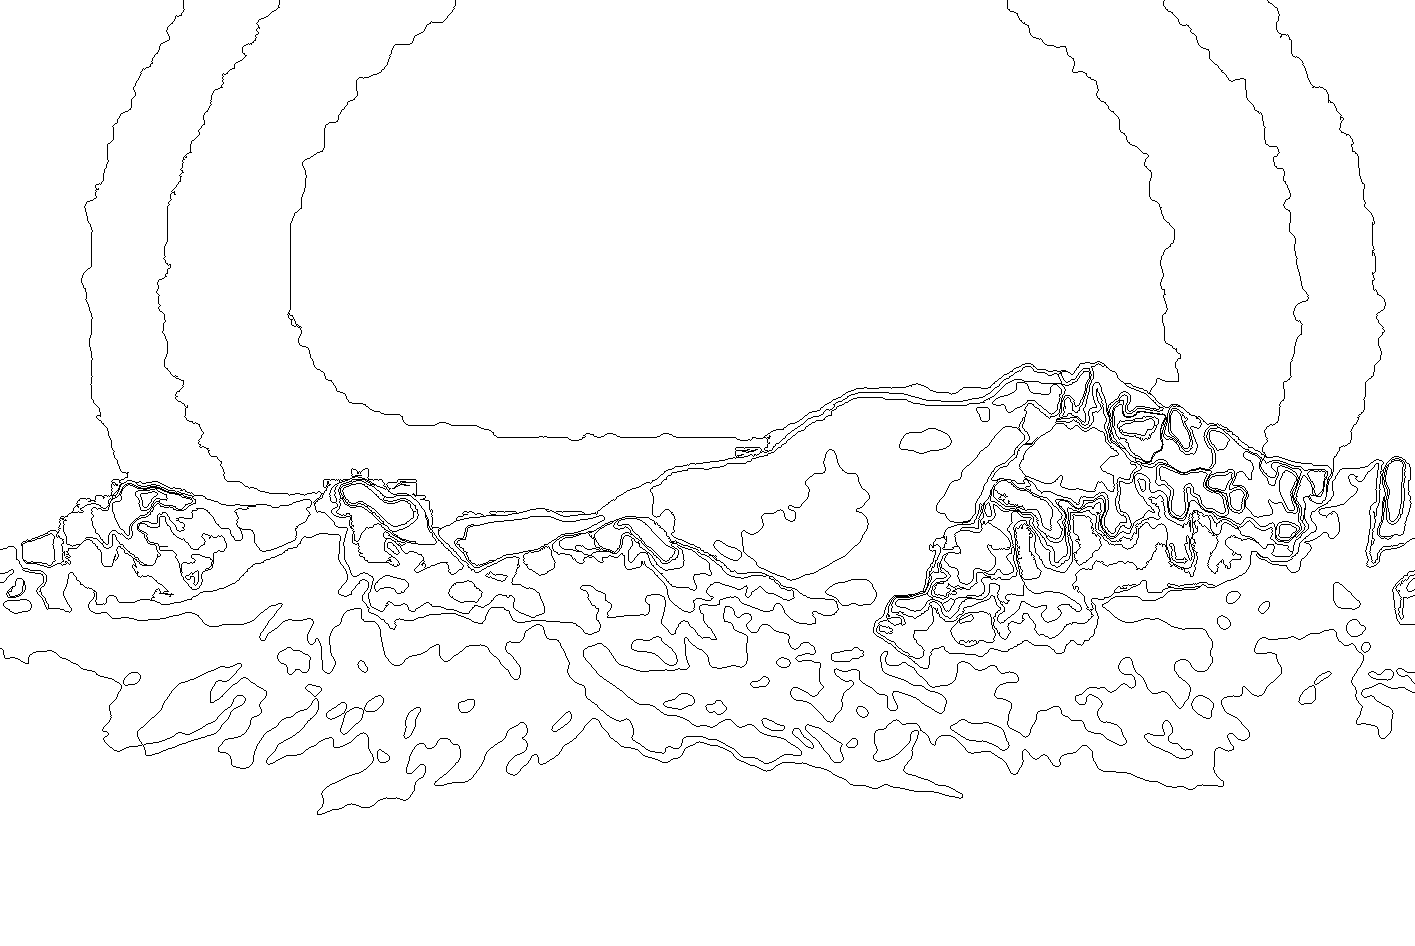

In [ ]:
# erstellt pixel matrix in Größe des Bildes: 0 = unbenutzt, 1 = benutzt
def createZonePixelList(size_x_1, size_y_1):
    zone_pixel_list = numpy.zeros((size_x_1, size_y_1))
    return zone_pixel_list

# print the edge image
def createEdgeImage(size_x, size_y, image_edge, edge_pixel_matrix, pixel_zone_matrix):
    for x in range(0, size_x):
        for y in range(0, size_y):
            if not edge_pixel_matrix[x, y]:
                zone_index = pixel_zone_matrix[x, y]
                image_edge = checkNewEdge(size_x, size_y, x, y, edge_pixel_matrix, zone_index, pixel_zone_matrix,
                                          image_edge)
    image_edge.save("Edge.jpg")
    return image_edge   

# Method to print all the edges
def checkNewEdge(size_x, size_y, x_to_check, y_to_check, edge_pixel_matrix, zone_index, pixel_zone_matrix, image_edge):
    # erstellt warteschlange
    queue_to_check = [[x_to_check, y_to_check]]
    # trägt pixel als bereits geprüften Pixel ein
    edge_pixel_matrix[x_to_check, y_to_check] = True

    # solange ein Pixel in der Warteschlange ist
    while len(queue_to_check) >= 1:
        # nimm Pixel zu prüfen
        x_to_check = queue_to_check[0][0]
        y_to_check = queue_to_check[0][1]
        # lösche Pixel aus Warteschlange
        queue_to_check.pop(0)
        # prüft von-Neumann-Nachbarn oben
        if y_to_check != 0 and not edge_pixel_matrix[x_to_check, y_to_check - 1]:
            this_index = pixel_zone_matrix[x_to_check, y_to_check - 1]
            if zone_index == this_index:
                queue_to_check.append([x_to_check, y_to_check - 1])
                edge_pixel_matrix[x_to_check, y_to_check - 1] = True
            else:
                image_edge.putpixel((x_to_check, y_to_check), (0, 0, 0))
        # prüft von-Neumann-Nachbarn rechts
        if x_to_check + 1 < size_x and not edge_pixel_matrix[x_to_check + 1, y_to_check]:
            this_index = pixel_zone_matrix[x_to_check + 1, y_to_check]
            if zone_index == this_index:
                queue_to_check.append([x_to_check + 1, y_to_check])
                edge_pixel_matrix[x_to_check + 1, y_to_check] = True
            else:
                image_edge.putpixel((x_to_check, y_to_check), (0, 0, 0))
        # prüft von-Neumann-Nachbarn unten
        if y_to_check + 1 < size_y and not edge_pixel_matrix[x_to_check, y_to_check + 1]:
            this_index = pixel_zone_matrix[x_to_check, y_to_check + 1]
            if zone_index == this_index:
                queue_to_check.append([x_to_check, y_to_check + 1])
                edge_pixel_matrix[x_to_check, y_to_check + 1] = True
            else:
                image_edge.putpixel((x_to_check, y_to_check), (0, 0, 0))
        # prüft von-Neumann-Nachbarn links
        if x_to_check != 0 and not edge_pixel_matrix[x_to_check - 1, y_to_check]:
            this_index = pixel_zone_matrix[x_to_check - 1, y_to_check]
            if zone_index == this_index:
                queue_to_check.append([x_to_check - 1, y_to_check])
                edge_pixel_matrix[x_to_check - 1, y_to_check] = True
            else:
                image_edge.putpixel((x_to_check, y_to_check), (0, 0, 0))
    return image_edge     

# erstellt das Kanten Bild und die dazugehörige boolean Matrix
image_edge = Image.new("RGB", (size_x, size_y), (255, 255, 255))
edge_pixel_matrix = createZonePixelList(size_x, size_y)
createEdgeImage(size_x, size_y, image_edge, edge_pixel_matrix, pixel_zone_matrix)

Da wir nun eine Liste mit den Center-Pixeln der Zonen besitzen, müssen nur noch die passenden Zahlen eingefügt werden.

Hierzu wird die "printImage" Methode aufgerufen.
Diese durchläuft alle Center-Pixel.
Für den Center-Pixel wird gezielt die Zahl (calculateColourNumber) berechnet.

Hierzu wird die Originalfarbe des Pixels mit den k Farben des K-Mean Algorithmus verglichen.
Der Index der K-Mean Farbe, die am nähesten an der Originalfarbe liegt, wird gewählt und an die "printImage" Methode übergeben.

Somit kann die Zahl in den Center-Pixel des Kantenbildes eingetragen werden.

In [ ]:
# gibt die zone als Bild aus
def printImage(centers, zone_list, font_size, k_mean_colour, pixel_colour):
    # liest das Kanten Bild ein, um dort die Zahlen einzuzeichnen
    im = cv2.imread("Edge.jpg")

    # geht alle Zonen durch
    for p in range(0, len(centers)):
        # nehme den center pixel
        pixel = centers[p]

        # zeichne Zahl in das neue Bild ein
        number = str(calculateColourNumber(pixel, k_mean_colour, pixel_colour))

        # LÜCKENFÜLLER FÜR BERECHNETEN PIXEL
        # teile die Zone durch 2 und zeichne auf Pixel die Zahl
        x_mid = pixel[0]
        y_mid = pixel[1]
        font = cv2.FONT_HERSHEY_SIMPLEX
        position = (x_mid - 3, y_mid + 3)
        fontScale = font_size
        n = int(int(number) - 1)
        fontColor = (0, 0, 0)

        cv2.putText(im, number,
                    position,
                    font,
                    fontScale,
                    fontColor)

    # speichert das neue Bild
    cv2.imwrite("Fertig.jpg", im)


# berechnet die Nummer der Zone
def calculateColourNumber(pixel, k_mean_colour, pixel_colour):
    # initialisiere die Nummer der Zone = 0 = Fehler (Da Zahlen bei 1 Anfangen)
    number = 0

    # nehme die Farbe der Zone anhand des Pixels (RGB)
    zone_colour = pixel_colour[pixel[0], pixel[1]]

    # kleinster Abstand startet bei dem größten möglichen Abstand (255+255+255)
    diff = 765
    # gehe nun alle Farben von K-Mean durch
    for c in range(0, len(k_mean_colour)):
        # berechne die Differenz zur k-mean Farbe
        diff_to_check = abs(k_mean_colour[c][0] - zone_colour[2]) + abs(k_mean_colour[c][1] - zone_colour[1]) + abs(
            k_mean_colour[c][2] - zone_colour[0])
        # wenn die Differenz kleiner als die vorherige ist, trage sie als neue Zonen Farbe ein
        if diff_to_check < diff:
            diff = diff_to_check
            number = c + 1

    return number
    
printImage(centers, zone_list, font_size, k_mean_colour, pixel_colour)

Damit der Nutzer nun auch alle Farben des Bildes auf einen Blick sehen kann, wird eine Farbpalette aller K-Mean Farben erstellt und unter dem Bild eingefügt.

Zum Erstellen der Palette wird zu Beginn die Anzahl der Farben berechnet, die in eine Reihe passen (amoamount_of_colours_in_a_row).
Diese setzt sich daraus zusammen, dass eine Farbe in der Palette die Größe 50 x 50 Pixel hat. 
Somit wird die Gesamtlänge des Bildes durch 50 geteilt.
Dann erhält man die Anzahl an Farben, die in eine Reihe passen.

In der ersten for-Schleife wird die farbige Palette erstellt.
Hierzu wird die k-Mean Farbe genommen und in einem Bereich von 50x50 Pixeln in ein neues weißes Bild gemalt.
Wenn alle k-Mean Farben gezeichnet wurden, müssen diese mit einer Zahl versehen werden, damit der Nutzer weiß, welche Farbe zu welcher Zahl gehört.

Hierzu durchläuft die zweite for-Schleife erneut alle Farben und fügt die Zahl in dem jeweiligen Farbfeld ein.
Je nachdem wie hell und wie dunkel die Farbe der Farbpalette ist, wird die Zahl weiß oder schwarz auf der Palette abgebildet.

In [ ]:
# erstellt eine Farbpalette mit k Farben
def create_palette(k_mean_colour, size_x):
    # Standradgröße einer Farbe der Farbpalette (50x50 Pixel)
    colour_size = 50
    # Anzahl der k-mean Farben
    amount_of_colours = len(k_mean_colour)
    # Anzahl der k-mean Farben die in eine Reihe passen
    amount_of_colours_in_a_row = int(size_x / colour_size)

    # erstellt das paletten Bild
    size_x = amount_of_colours_in_a_row * colour_size

    amount_of_rows = amount_of_colours / amount_of_colours_in_a_row
    if amount_of_rows > int(amount_of_rows):
        amount_of_rows = int(amount_of_rows) + 1
    else:
        amount_of_rows = int(amount_of_rows)
    size_y = colour_size * amount_of_rows

    image_palette = Image.new("RGB", (int(size_x), int(size_y)), (255, 255, 255))

    # Farben-Zähler
    colour_counter = 0
    # für jede Reihe
    for row in range(0, amount_of_rows):
        # für alle Farben in dieser Reihe
        for colour_in_row in range(0, amount_of_colours_in_a_row):

            c_x = colour_size * colour_in_row
            c_y = colour_size * row

            for x in range(0, colour_size):
                x_c = x + c_x
                for y in range(0, colour_size):
                    y_c = y + c_y

                    if colour_counter < amount_of_colours:
                        image_palette.putpixel((x_c, y_c), (
                            int(k_mean_colour[colour_counter][2]), int(k_mean_colour[colour_counter][1]),
                            int(k_mean_colour[colour_counter][0])))
            colour_counter = colour_counter + 1
    image_palette.save('palette.png')
    palette = cv2.imread("palette.png")
    palette = palette.copy()

    # zeichne Zahl in das neue Bild ein
    colour = 0
    number = 1

    for row in range(0, amount_of_rows):
        for colour_in_row in range(0, amount_of_colours_in_a_row):
            if colour < amount_of_colours:
                # LÜCKENFÜLLER FÜR BERECHNETEN PIXEL
                # teile die Zone durch 2 und zeichne auf Pixel die Zahl
                x_mid = int((colour_in_row * colour_size)) + 10
                if int(number) > 9:
                    x_mid = int((colour_in_row * colour_size))
                y_mid = (row + 1) * 40
                font = cv2.FONT_HERSHEY_SIMPLEX
                position = (x_mid, y_mid)
                fontScale = 1

                colour_spectrum = k_mean_colour[colour][0] + k_mean_colour[colour][1] + k_mean_colour[colour][2]
                fontColor = (0, 0, 0)
                if colour_spectrum < 200:
                    fontColor = (255, 255, 255)

                cv2.putText(palette, str(number),
                            position,
                            font,
                            fontScale,
                            fontColor)
                colour = colour + 1
                number = number + 1
    cv2.imwrite("palette.png", palette)

# erstelle die Farbpalette
create_palette(k_mean_colour, size_x)

Zu guter Letzt müssen die beiden Bilder (Kanten Bild / Farbpalette) verbunden werden.
Hierzu verwenden wir einen Algorithmus, der die Farbpalette unterhalb des Kantenbilds einfügt.

Das fertige Bild wird nun als "Ergebnis.jpg" abgespeichert.

In [ ]:
# kombiniere das segmentierte Bild und die Farbpalette zu einem Bild
def combineImage():
    images = [Image.open(x) for x in ['Fertig.jpg', 'palette.png']]
    widths, heights = zip(*(i.size for i in images))

    total_height = sum(heights)
    max_width = max(widths)

    new_im = Image.new('RGB', (max_width, total_height), (255, 255, 255))

    y_offset = 0
    for im in images:
        new_im.paste(im, (0, y_offset))
        y_offset += im.size[1]

    new_im.save('Ergebnis.jpg')

combineImage()    

# **3.2 Umsetzung: GUI**

In diesem Abschnitt werden die verschiedenen Elemente und Designentscheidungen der GUI erklärt und vorgestellt.

Unsere GUI verwendet in großen Teilen die gegebene Webapp. Dies ermöglicht die Verwendung der CEWE API. 
Ein Nutzer kann einen Account bei CEWE anlegen und dort Bilder hochladen. Mit seinen Anmeldedaten kann dann in unserer Anwendung auf diese Bilder zugegriffen werden. 

Hat sich ein Nutzer angemeldet, kann mit dem *Load Images*-Button die Gallerie von Bildern des CEWE-Accounts angezeigt werden. Der *Load more*-Button am unteren Rand erlaubt das Laden weiteer Bilder aus der Gallerie.

## **3.2.1 Schwierigkeitsgrad**

Wie in der Zielsetzung definiert, muss ein Nutzer die Möglichkeit haben, verschiedene Schwierigkeitsgrade auszuwählen.
Dieser Schwierigkeitsgrad würde sich auf Variablen wie minimale Größe einer Zone und Anzahl Farben auswirken
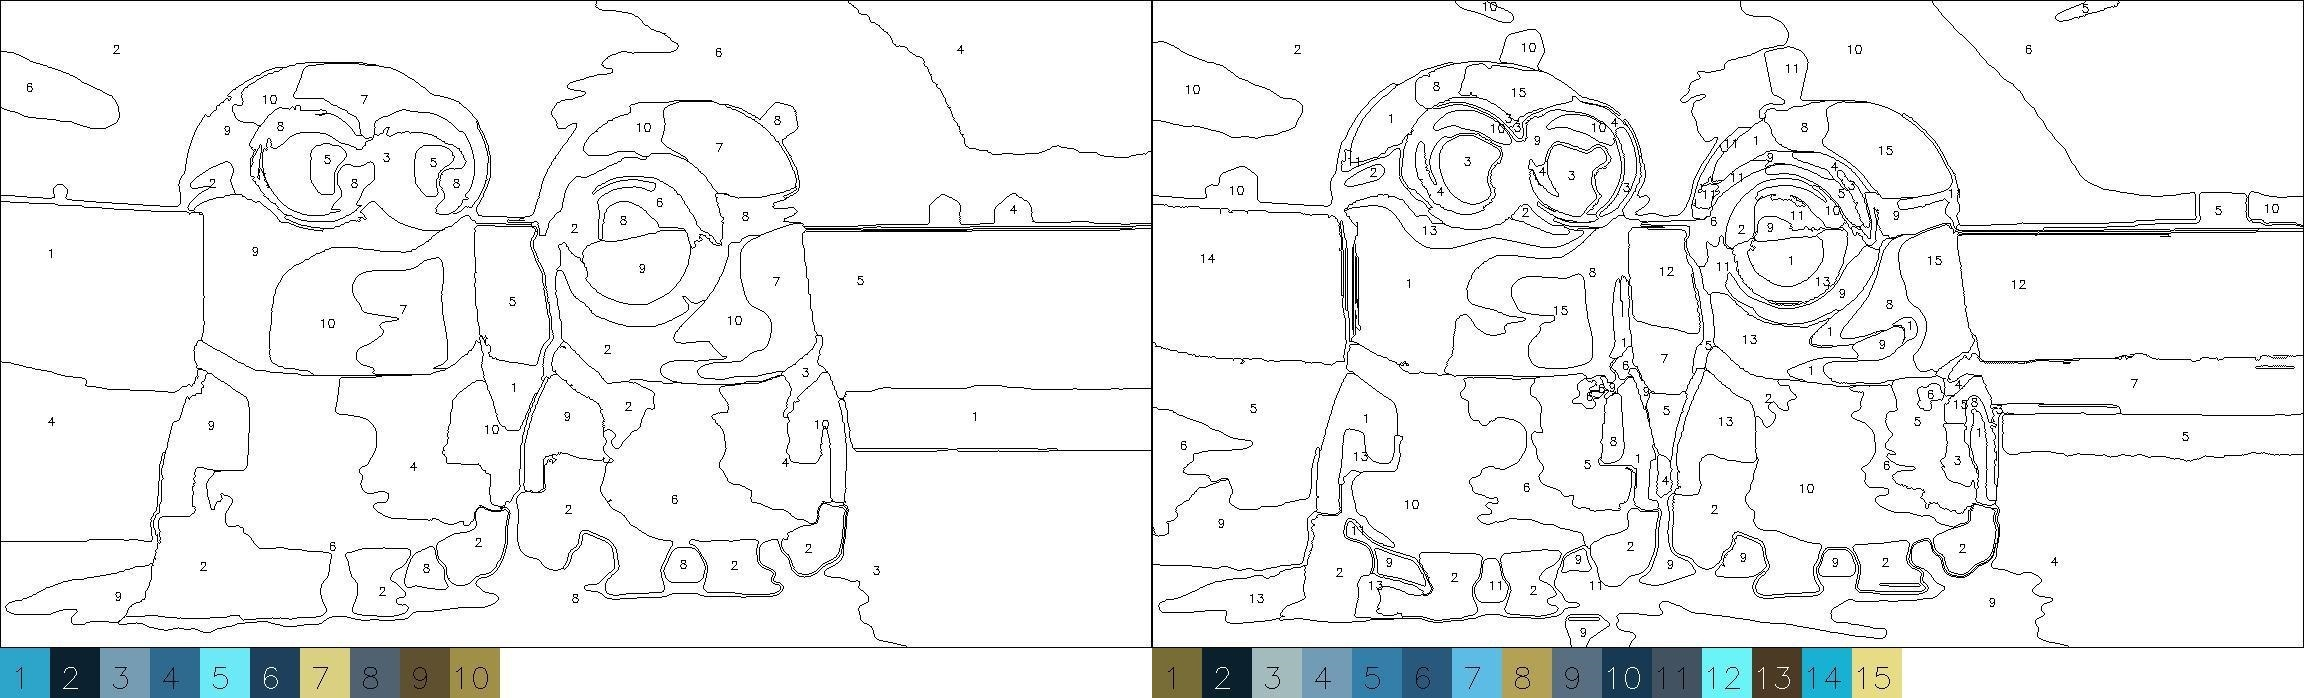



Um ein flexibles Anpassen der Schwierigkeit zu ermöglichen, wurden bei der Implementierung zunächst mehrere Schieberegler für die verschiedenen Variablen realisiert. So konnte ein Nutzer individuell einstellen, wie das Ausmalbild am Ende aussehen soll.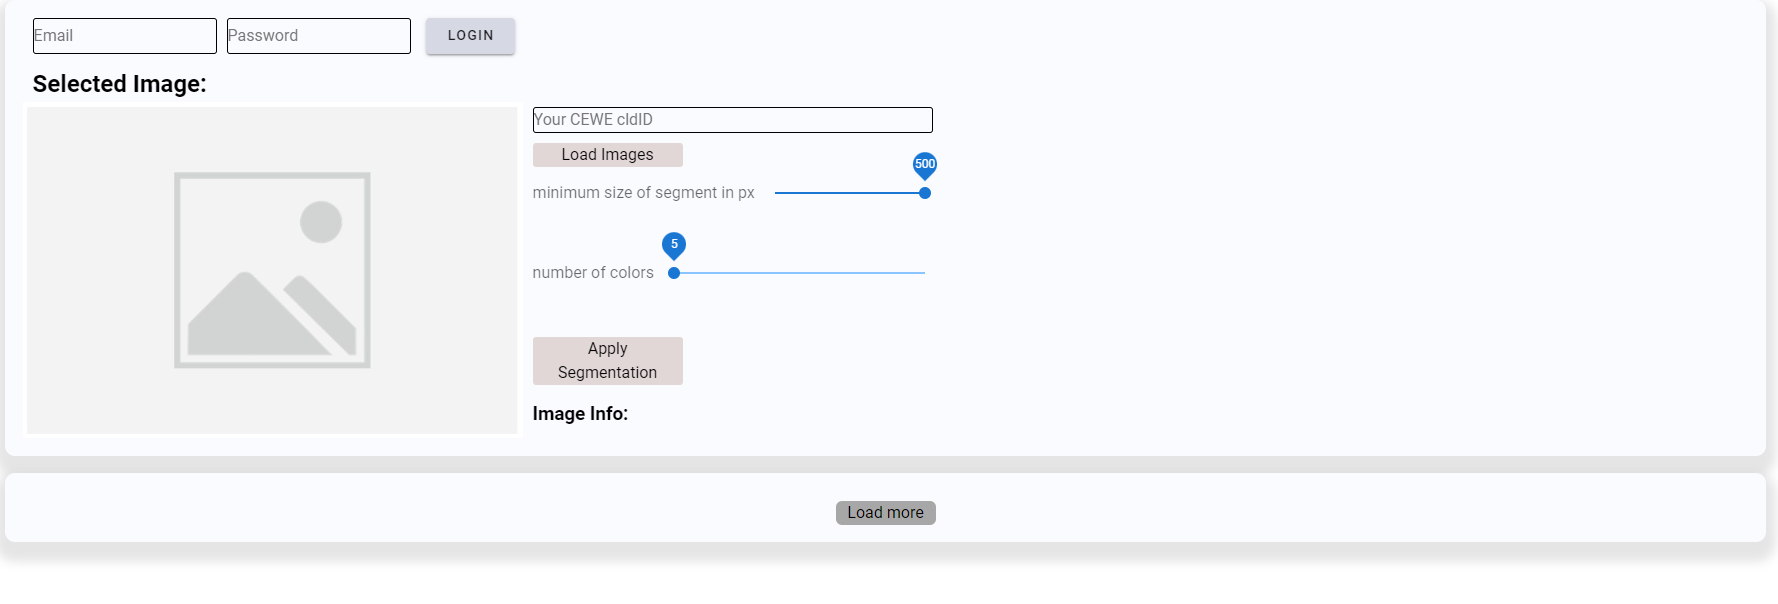

Diese Schieberegler wurden im weiteren Verlauf der Entwicklung zu einem Regler zusammengefasst, an dem ein Schwierigkeitsgrad zwischen 1 und 5 ausgewählt werden kann. Dies erhöht die Bedienfreundlichkeit der Anwendung.
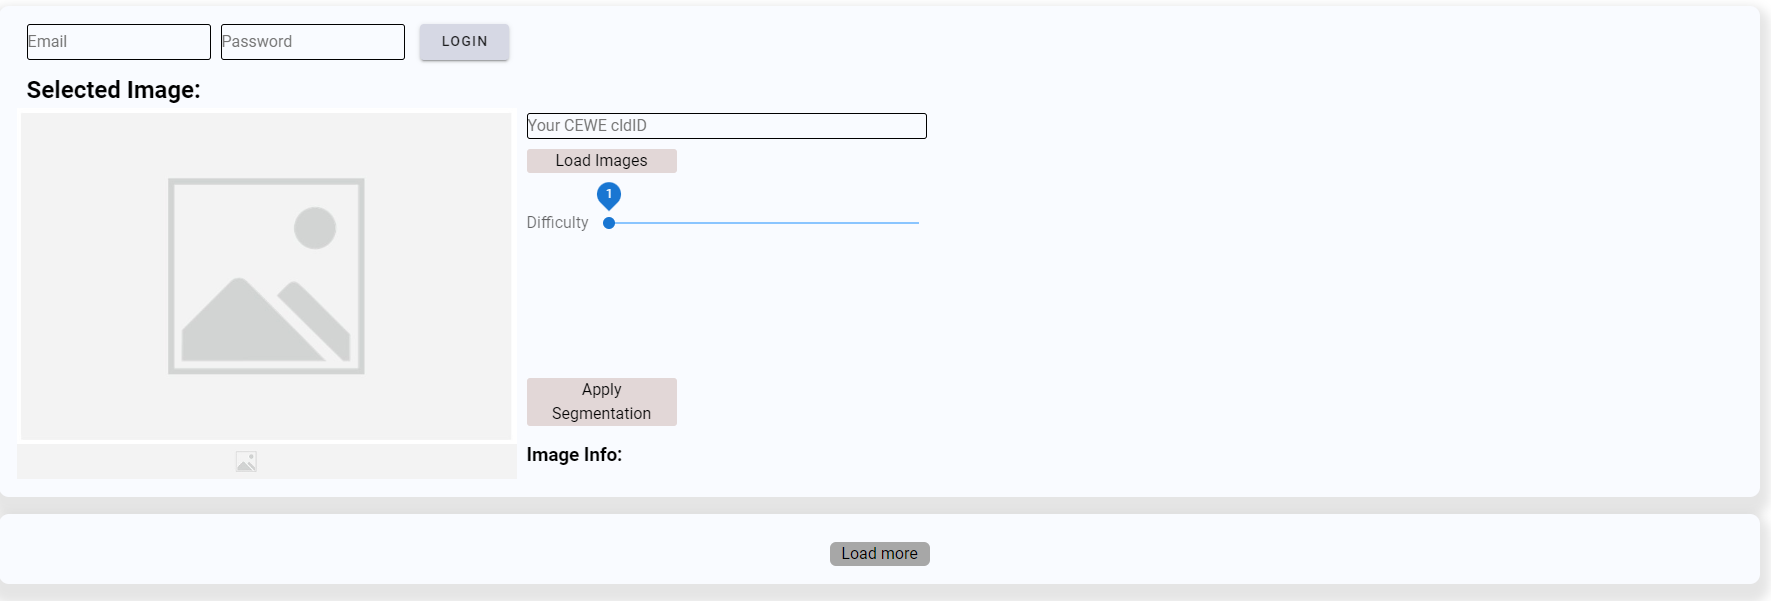

Hat ein Nutzer ein Bild ausgewählt und einen Schwierigkeitsgrad eingestellt, so kann mit dem *Apply Segmentation*-Button das Backend aufgerufen werden.
Während die Bearbeitung des Bildes läuft, wird ein lade-Symbol angezeigt, damit der Nutzer sieht, das gerade im Hintergrund Prozesse laufen.

Sobald die Bildberarbeitung abgeschlossen ist, wird das Ausmalbild, samt Farbpalette, in der Webapp angezeigt und kann gespeichert werden.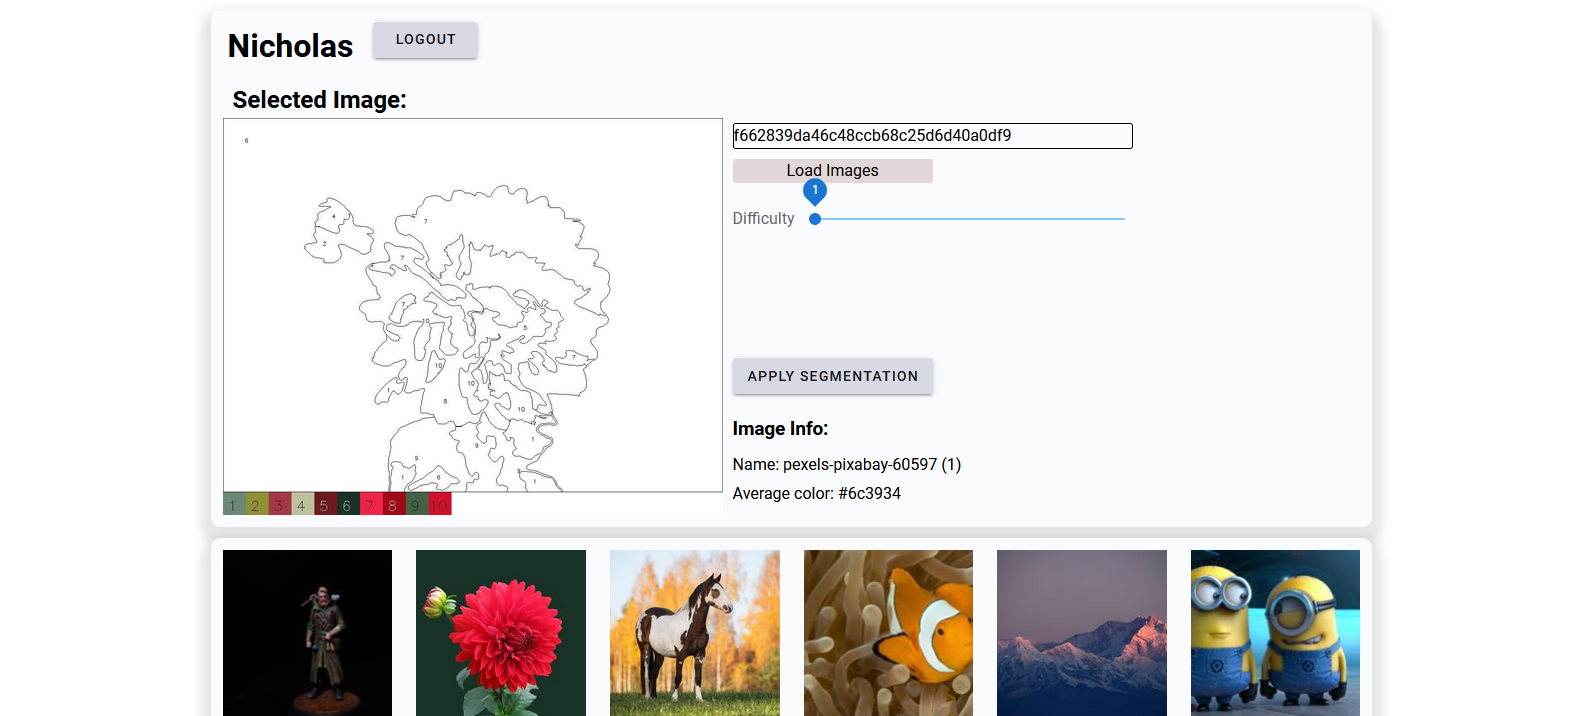

# **5. Ausblick**
Im folgenden Kapitel wollen wir einmal vorstellen welche Ideen wir noch hätten, die man mit mehr Zeit, vielleicht hätte umsetzen können.



## **5.1 Erhalten von wichtigen Details des Ausgangsbildes**

Bei unserem Bildverarbeitungsprozess haben wir gezielt versucht den Detailgrad eines Bildes zu verringern. Wir wollten ein gegebenes Bild bis zu dem Grad vereinfachen, dass es eine Laie ausmalen kann. Bei den meisten Details ist der Verlust dieser, nicht von grosser Bedeutung. Bei manchen Details gehen durch deren Verlust jedoch wichtige Informationen verloren. Zum Beispiel werden durch die Verabeitung bei einer Person, die nicht direkt im Vordergrund ist, wichtige Gesichtsmerkmale, wie Augen, Mund und Nase, wahrscheinlich nicht mehr erkennbar sein.

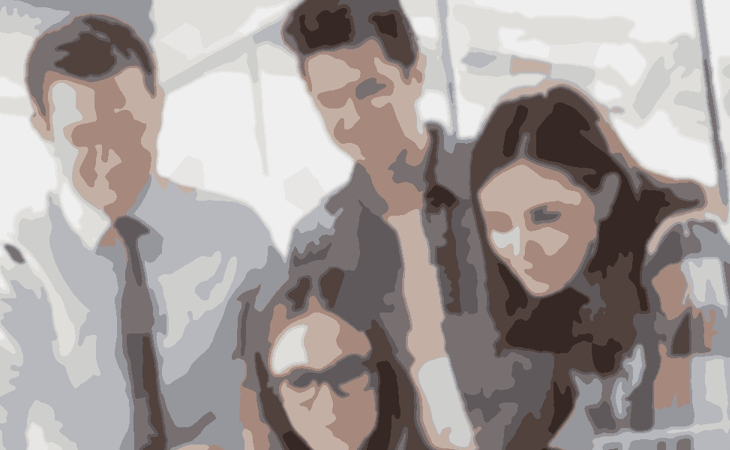

Auch können andere Objekte von Interesse, wie dieser Wolf, nach der Verarbeitung nur noch schwer erkennbar sein.

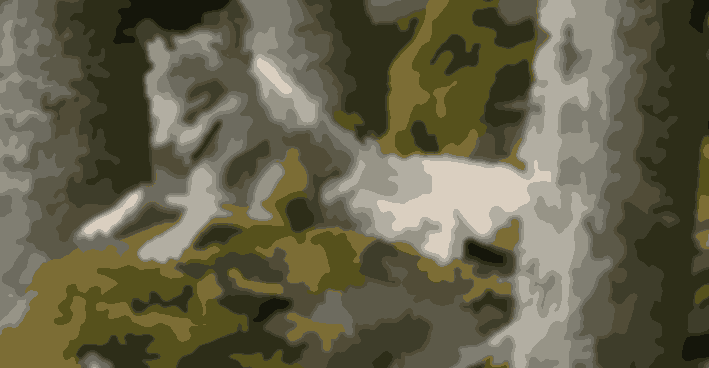

Durch eine Objekt- und Gesichtserkennung wäre es vielleicht möglich gewesen, wichtige Details, wie Gesichtsmerkmale oder Details anderer Art, zu erhalten. Wenn von dem Programm ein Objekt von Interesse erkannt wird, kann das Programm diesen Bereich feiner bearbeiten. Also da für diesen Bereich z.B. mehr Superpixel erstellt werden, oder dass Gesichtsmerkmale 1 zu 1 übernommen werden.

## **5.2 Schmale Zonen genauer erkennen**

Wir konnten durch unseren Algorithmus viele schmale Zonen, also Zonen die nur wenige Pixel breit sind und so nur schwer ausmalbar wären, entfernen. Jedoch werden durch diesen Algorithmus keine Zonen entfernt, wenn sie den grössten Teil sehr schmal sind, aber an einem Teil, doch grösser sind, als die zugelassene Mindestbreite.

Wenn wir analysieren könnten, wie gross der Bereich einer Zone in Prozent ist, der kleiner ist als die zugelassene Mindestbreite, dann hätten wir die Möglichkeit zu bestimmen, dass alle Zonen die zu einem bestimmten Prozentanteil kleiner sind als die zugelassene Mindestbreite, trotz dessen dass sie an einer Stelle breiter sind, zu entfernen.

## **5.3 Fortschrittanzeige**

Wenn ein Bild verarbeitet wird, durchläuft es mehrer Schritte. Diese können zusammen, bis ein Bild fertig bearbeitet wurde, schon eine gewisse Zeit in Anspruch nehmen. Um den Nutzer besseres Feedback über den aktuellen Stand der Vearbeitung geben zu können, könnten wir dem Nutzer anzeigen in welchem Verabeitungsschritt die Berechnung gerade ist, wie viele Bearbeitungsschritte  bereits erledigt sind und wie viele Bearbeitungsschritte noch fehlen.

*Beispielausgabe für den Nutzer:* ***Schritt 3/8: Bild wird in Superpixel unterteilt***

Mit einer solchen Ausgabe kann der Nutzer den Stand der Verarbeitung besser einschätzen und die Usability unseres Systems wird verbessert.

## **5.4 Preview**

Die Verarbeitung eines Bildes, kann wie gerade schon erwähnt, einige Zeit in Anspruch nehmen. 

Damit ein Nutzer schon vor der Verarbeitung einschätzen kann, ob er mit dem Ergebnis zufrieden sein wird. Könnten wir das Bild in einer runterskalierten Version, auf die gleiche Art und Weise, wie das Originalbild, verarbeiten und dann dem Nutzer als Preview anzeigen. Durch das Runterskalieren dauert die Verarbeitung wesentlich kürzer und der Nutzer könnte anhand der Preview entscheiden, ob er das Bild in Originalgrösse verarbeiten möchte oder nicht. Somit müsste der Nutzer nicht auf nicht zufriedenstellende Ergebnisse warten, was auch die Usability unseres Systems verbessern würde.

## **5.5 Speichern des Ergebnisses als Vektorgrafik**

Wir speichern unser Ergebnis als Pixelgrafik(jpg) ab. Dadurch entsteht Rauschen in der Nähe von Kanten. Das hinterlässt einen unschönen Eindruck.

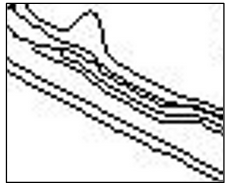

Durch die Abspeicherung als Vektorgrafik anstatt als Pixelgrafik, wären alle Bereiche die nicht die Kanten sind transparent. Somit hätten wir kein Rauschen mehr. Zudem wäre das Bild beliebig vergrösserbar, ohne Schärfe zu verlieren.

## **5.6 Einzelne Ausgaben für Ergebnis, Farbpalette und ausgemaltes Ergebnis**

Da wir Schwierigkeiten hatten mehrere Bilder über die GUI auszugeben, hatten wir die Farbpalette unten an das Ergebnis angefügt und das Zwischenergebnis aus Schritt 5 der Umsetzung gar nicht ausgegeben.

Wenn wir die Möglichkeit hätten mehrere Bilder separat auszugeben, könnten wir das Ergebnis und die Farbpalette einzeln ausgeben. Wenn man das Bild nach dem Ausmalen z.B. aufhängen möchte, stört die Farbpalette nur. Durch das einzelne Ausgeben dieser beiden Bilder, könnte das verhindert werden. Zudem könnten wir unser Zwischenergebnis, als Vorlage zum Ausmalen, mit ausgeben.


# **6. Fazit**

Abschließend lässt sich sagen, dass die Anforderungen, die in der Zielsetzung definiert wurden, trotz aller aufgetretenen Probleme erfüllt wurden. 
Gerade diese Probleme haben dazu geführt, dass neue Kenntnisse in Python erworben wurden, und eigene Verfahren entwickelt wurden. Statt sich auf vorgefertigte Libraries zu verlassen, wurden viele Probleme individuell gelöst.

Gut verlief auch die Kommunikation innerhalb des Teams und trotz krankheitsbedingtem, zwischenzeitlichem Ausfall eines Teammitglieds lief die Arbeitsteilung und zeitliche Planung meist ohne Schwierigkeiten.

Zuständigkeiten wurden anhand von bereits vorhandenen Erfahrungen in verschiedenen Bereichen und Programmiersprachen verteilt und bei neu auftretenden Bugs wurden stets schnell innerhalb der Gruppe Lösungen diskutiert.

In Verbindung mit dem Vorlesungsstoff hat dieses Projekt die Grundlagen und Anwendungsfelder der Bildverarbeitung gut veranschaulicht und erste praktische Erfahrungen in diesem Gebiet ermöglicht.
